# Cow behaviour labelling
Using a pre-trained model.

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()
INPUT_PATH: str = os.environ["INPUT_PATH"]
SCRIPT_PATH: str = os.environ["SCRIPT_PATH"]
OUTPUT_PATH: str = os.environ["OUTPUT_PATH"]

In [2]:
import pathlib

DATA_PATH: str = os.path.abspath(path="{}".format(INPUT_PATH))
OUTPUT_PATH = os.path.abspath(OUTPUT_PATH)

files: list[str] = os.listdir(path=DATA_PATH)
input_files: list[pathlib.PosixPath] = [
    pathlib.Path(DATA_PATH, file).resolve() for file in files
]

In [3]:
for f in input_files[:2]:
    print(f.name)

MOS2E03230475_30Hz_proc.parquet
MOS2E03230488_30Hz_proc.parquet


In [4]:
import logging

logging.basicConfig(
    format="%(levelname)s: %(message)s",
)

In [5]:
import tensorflow as tf

print(tf.__version__)

training_device: str = "cpu"

if str.lower(training_device) == "cpu":
    tf.config.set_visible_devices(
        devices=[],
        device_type="GPU",
    )
else:
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-02-08 11:16:30.192414: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 11:16:31.742833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0


In [6]:
import random

import keras

window_size: int = 600  # 300: 10 seconds
window_per_epoch: int = 200
epoch: int = 1
batch_size: int = 64
# random.seed(715) # 715 looks good.
random.seed(785)  # 785 makes "other" looks bad, otherwise is good.


model: keras.Model = keras.models.load_model(
    filepath=pathlib.Path(SCRIPT_PATH, "cow-model").resolve()
)
model.summary()

Model: "cow_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             multiple                  13184     
                                                                 
 conv1d_1 (Conv1D)           multiple                  24640     
                                                                 
 conv1d_2 (Conv1D)           multiple                  6176      
                                                                 
 batch_normalization (Batch  multiple                  512       
 Normalization)                                                  
                                                                 
 conv1d_transpose (Conv1DTr  multiple                  1552      
 anspose)                                                        
                                                                 
 conv1d_transpose_1 (Conv1D  multiple                  39

In [7]:
for f in input_files:
    current_sensor: str = f.stem.split(sep="_")[0]
    sensor_path: pathlib.PosixPath = pathlib.Path(OUTPUT_PATH, current_sensor).resolve()
    print(sensor_path)

/mnt/disk1/Ellinbank/AnalyticOutputs/prediction_output/MOS2E03230475
/mnt/disk1/Ellinbank/AnalyticOutputs/prediction_output/MOS2E03230488
/mnt/disk1/Ellinbank/AnalyticOutputs/prediction_output/MOS2E03230532


In [7]:
import gc
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas
import pandas.io.parsers.readers
import pyarrow.parquet
from operation import clean_data, label_data

for f in input_files:
    current_sensor: str = f.stem.split(sep="_")[0]
    sensor_path: pathlib.PosixPath = pathlib.Path(OUTPUT_PATH, current_sensor).resolve()
    try:
        os.mkdir(path=sensor_path)
        logging.info(msg="Start processing {}.".format(current_sensor))
    except FileExistsError:
        os.rmdir(path=sensor_path)
        os.mkdir(path=sensor_path)
        logging.warning(
            msg="Start processing {} with directory recreated.".format(current_sensor)
        )
    # continue
    parquet_file: pyarrow.parquet.core.ParquetFile = pyarrow.parquet.ParquetFile(
        source=f,
    )
    for batch in parquet_file.iter_batches(batch_size=1800000):
        batch_df: pandas.DataFrame = batch.to_pandas()
        batch_df["timestamps"] = batch_df["timestamps"].apply(
            lambda x: datetime.strftime(x, "%Y-%m-%d %H:%M:%S.%f")
        )
        full_data: pandas.DataFrame = clean_data(full_data=batch_df)
        del batch_df

        labels: np.ndarray = label_data(
            raw_data=full_data,
            model=model,
            window_size=window_size,
            batch_size=batch_size,
        )

        with open(
            file=pathlib.Path(
                sensor_path,
                "{}_predictions.txt".format(current_sensor),
            ).resolve(),
            mode="ab",
        ) as file:
            np.savetxt(
                fname=file,
                X=labels,
                fmt="%s",
            )

        time_stamps: np.ndarray = full_data["timestamps"].to_numpy()
        with open(
            file=pathlib.Path(
                sensor_path,
                "{}_timestamps.txt".format(current_sensor),
            ).resolve(),
            mode="ab",
        ) as file:
            np.savetxt(
                fname=file,
                X=time_stamps,
                fmt="%s",
            )

        gc.collect()

<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>


<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>


<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>
<class 'pyarrow.lib.RecordBatch'>


## Predictions and timestamps merging.
Merging separated `.txt` files to a new one.

In [8]:
import gc

import pandas
import pandas.io.parsers.readers

for f in input_files:
    current_sensor: str = f.stem.split(sep="_")[0]
    sensor_path: pathlib.PosixPath = pathlib.Path(OUTPUT_PATH, current_sensor).resolve()
    # Remove all the merged file before create a new one.
    try:
        os.remove(
            path=pathlib.Path(
                sensor_path,
                "{}_timestamp-label.csv".format(current_sensor),
            ).resolve()
        )
    except FileNotFoundError:
        pass

    # Read the timestamp and label file and merge them into a new one.
    ts_df: pandas.DataFrame = pandas.read_csv(
        filepath_or_buffer=pathlib.Path(
            sensor_path,
            "{}_timestamps.txt".format(current_sensor),
        ).resolve(),
        sep=",",
        names=["timestamps"],
        header=None,
    )
    label_df: pandas.DataFrame = pandas.read_csv(
        filepath_or_buffer=pathlib.Path(
            sensor_path,
            "{}_predictions.txt".format(current_sensor),
        ).resolve(),
        sep=",",
        names=["predicted_labels"],
        header=None,
    )
    tsl_df: pandas.DataFrame = pandas.concat(
        objs=[ts_df, label_df],
        axis=1,
    )
    # Output the merged DataFrame.
    tsl_df.to_csv(
        path_or_buf=pathlib.Path(
            sensor_path,
            "{}_timestamp-label.csv".format(current_sensor),
        ).resolve(),
        sep=",",
        index=False,
    )
    gc.collect()

## Output.
Visualisations and summaries.

/home/mdinh/ellinbank_project/new_code/data_labelling/visualisation.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  subplot_tuple: tuple = plt.subplots(


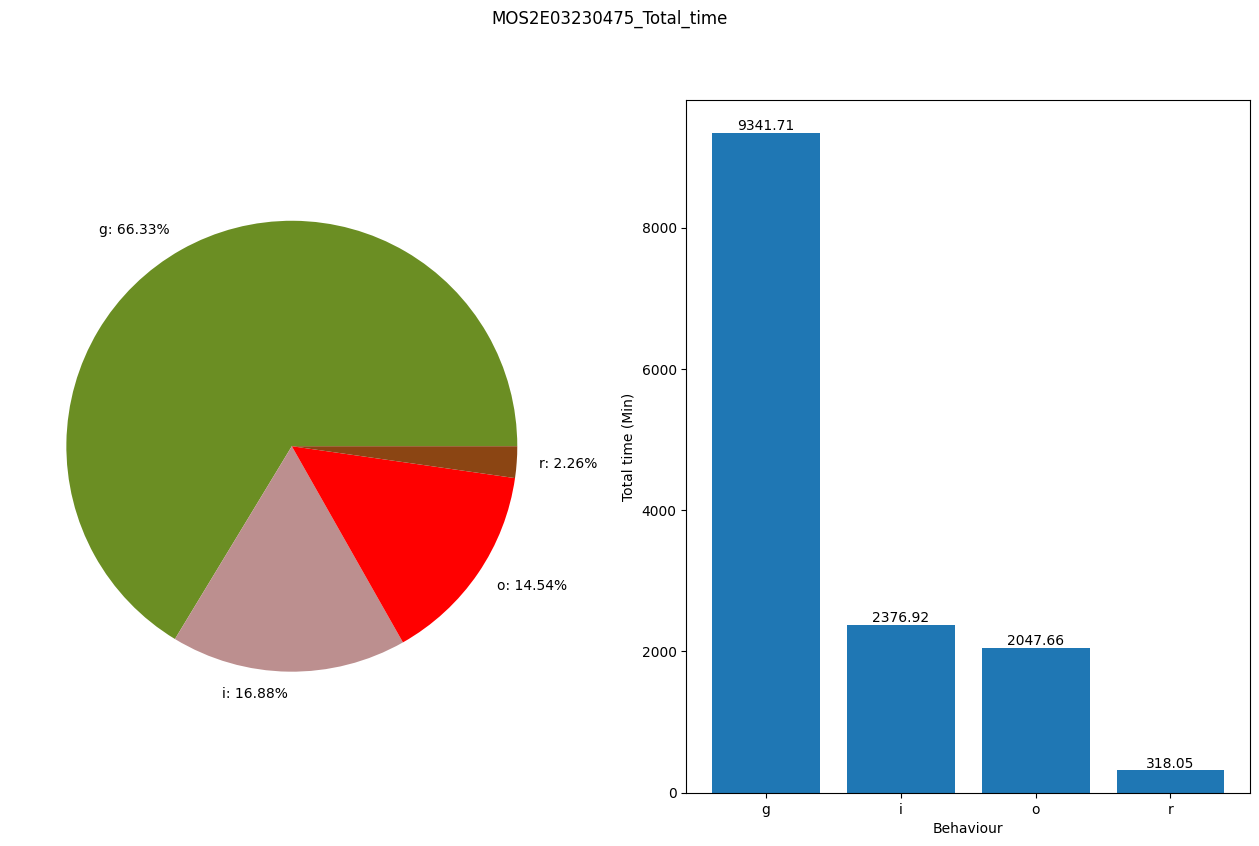

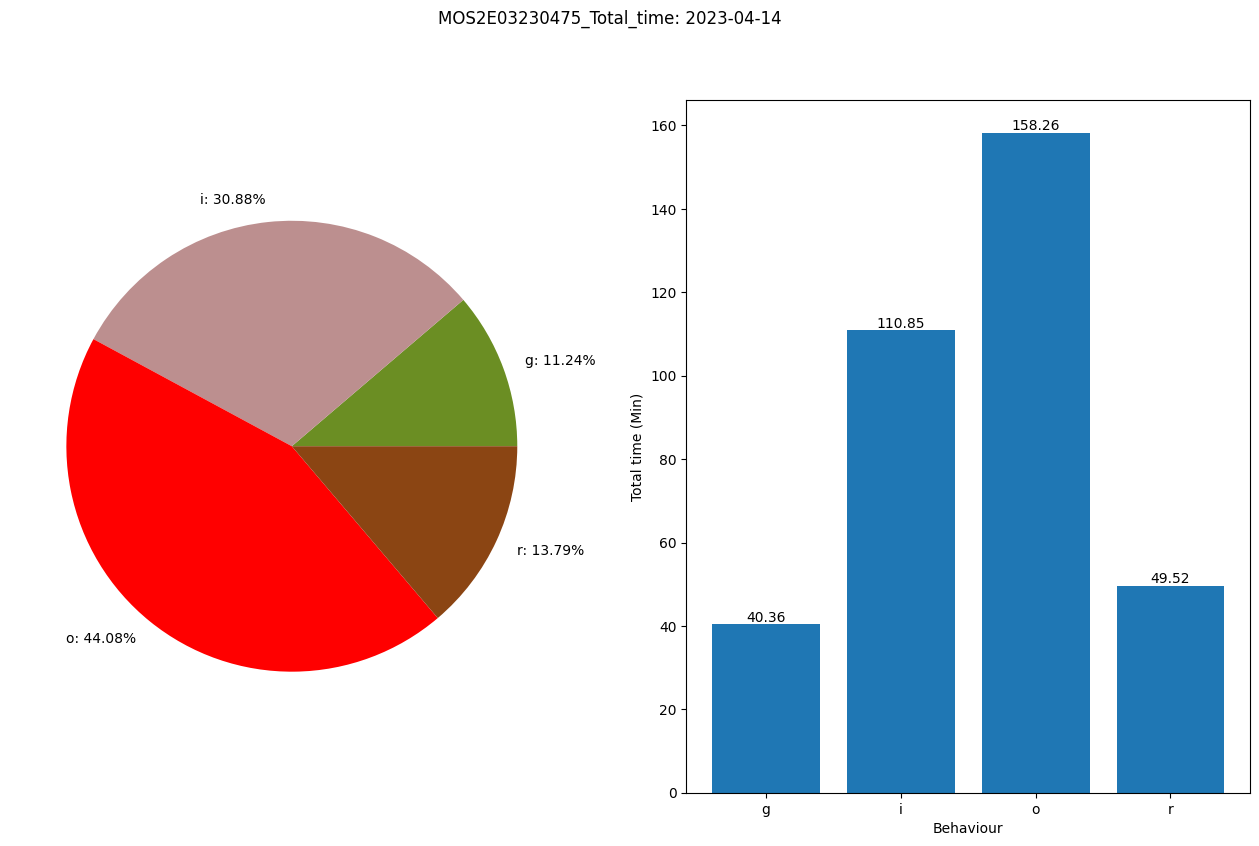

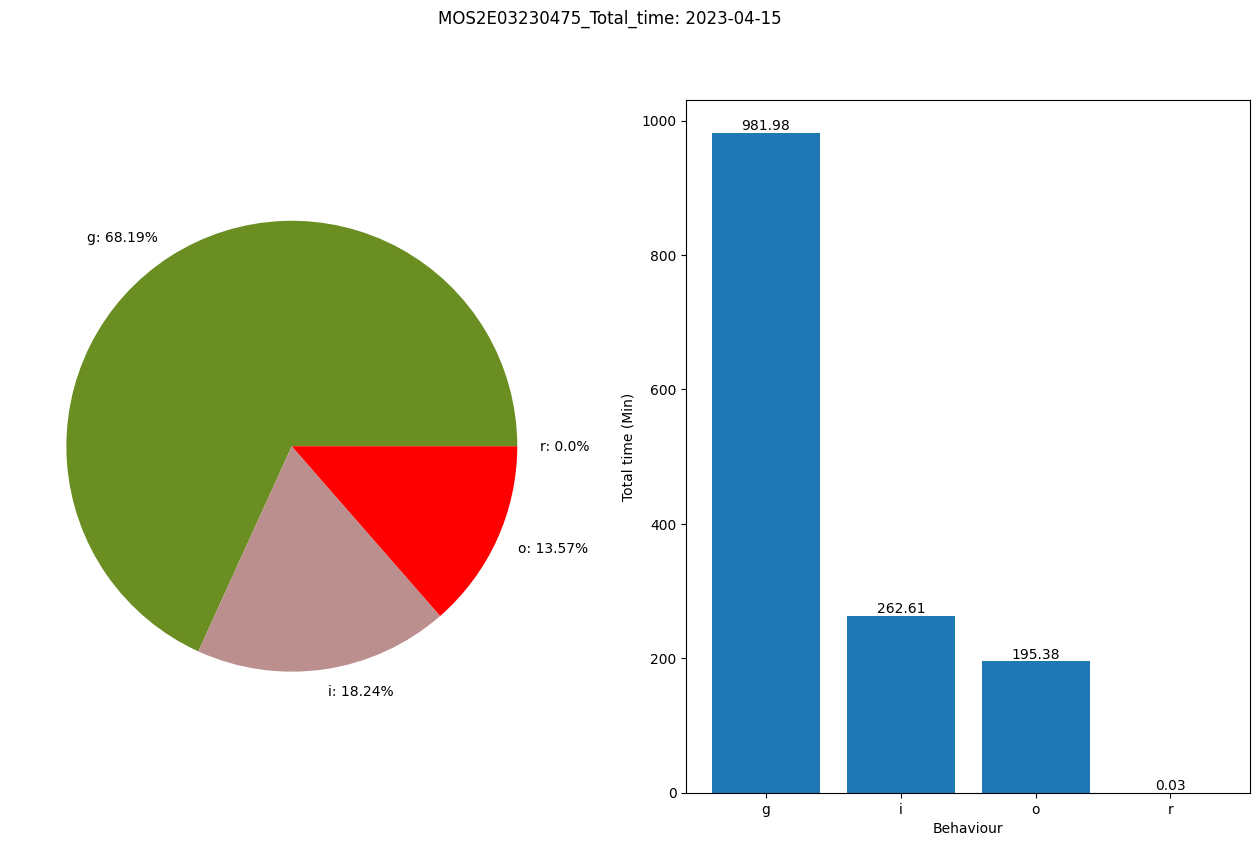

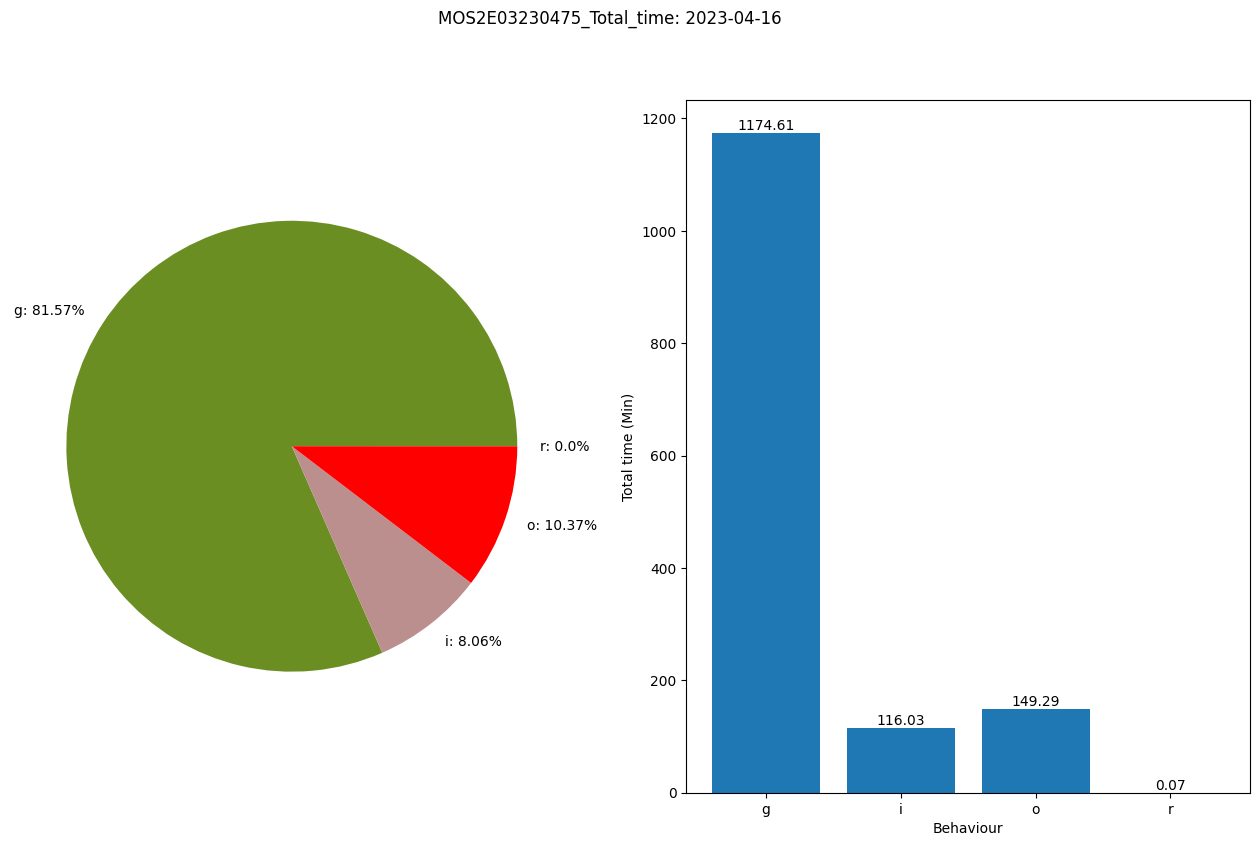

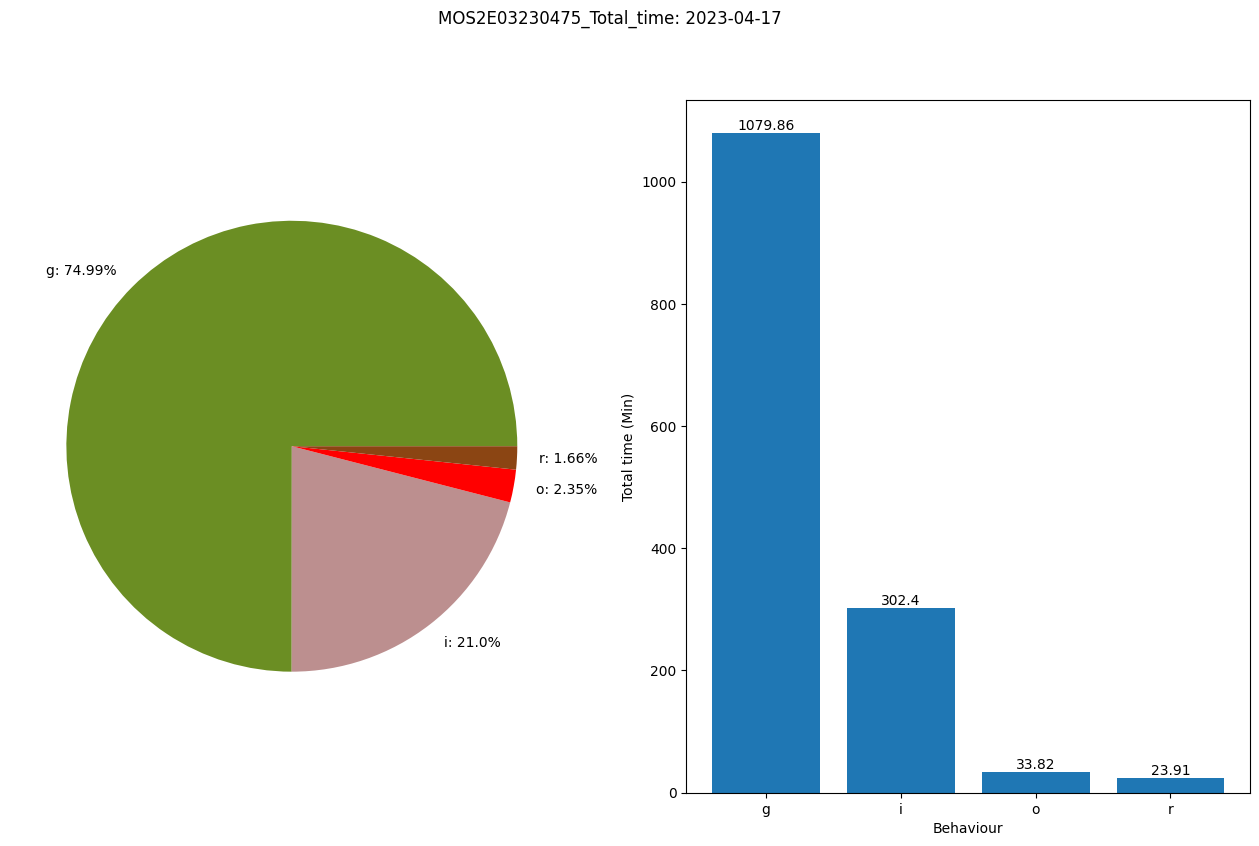

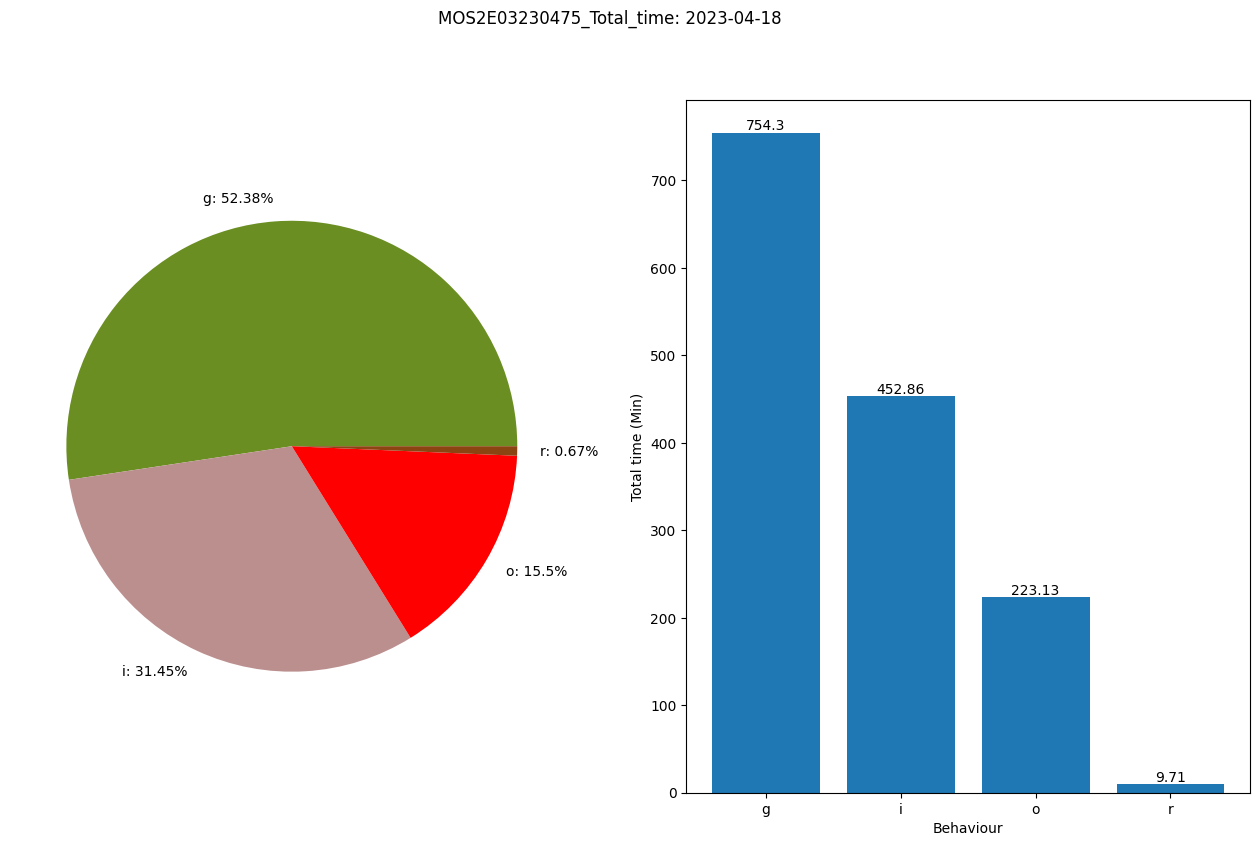

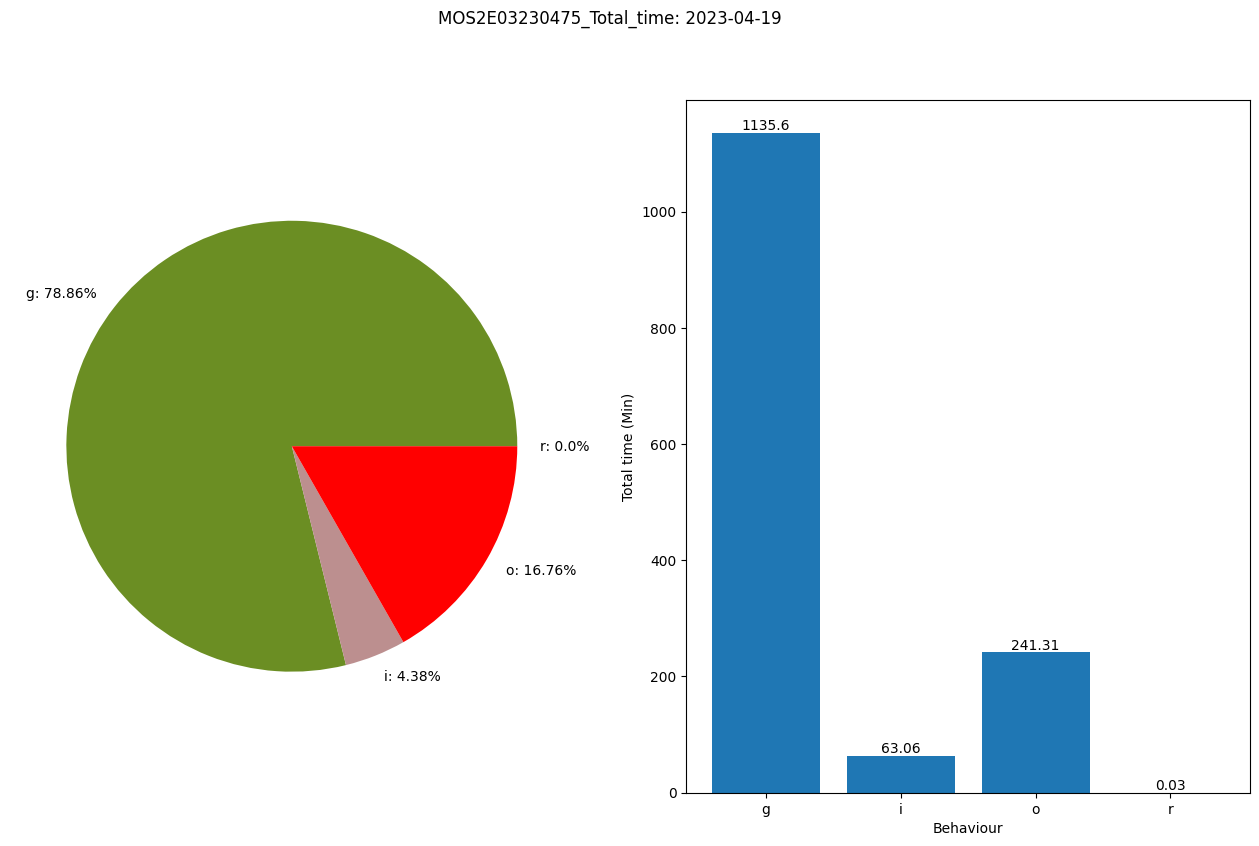

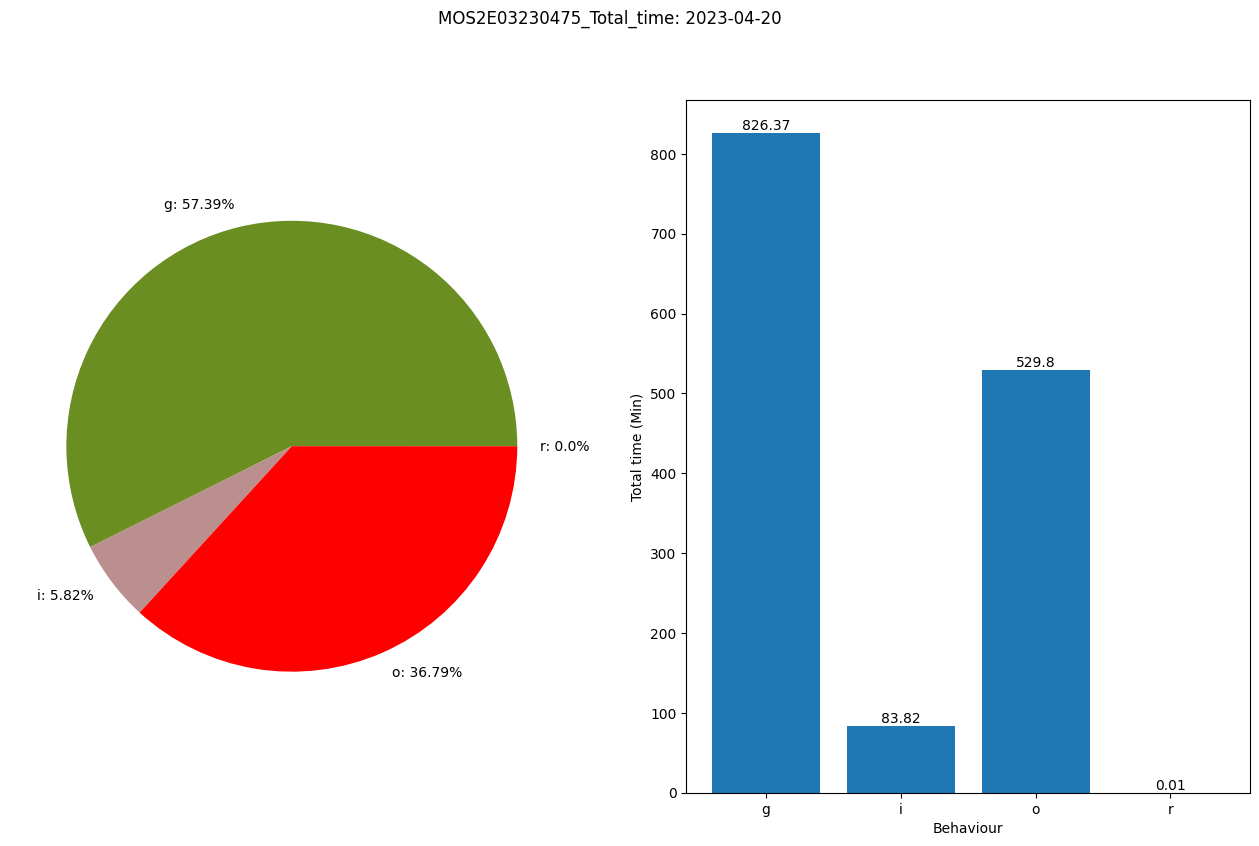

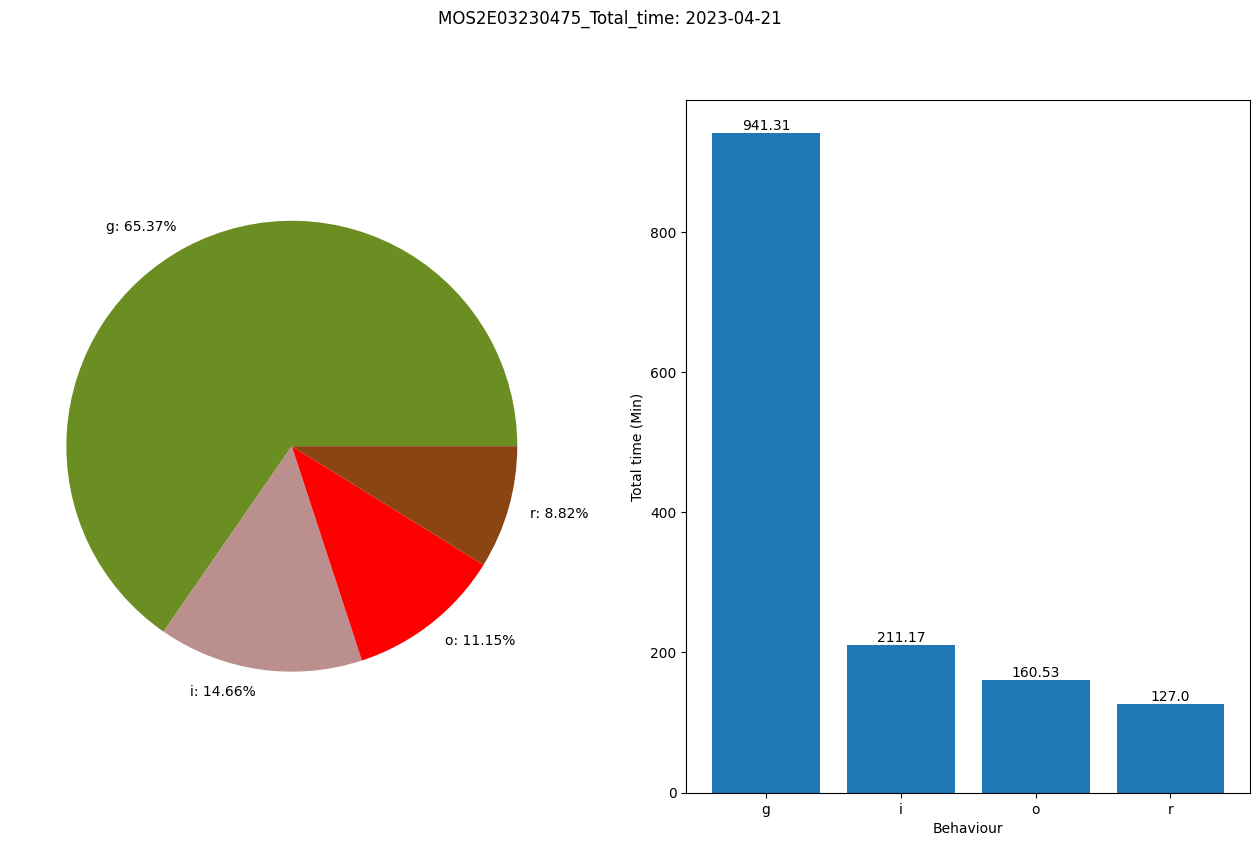

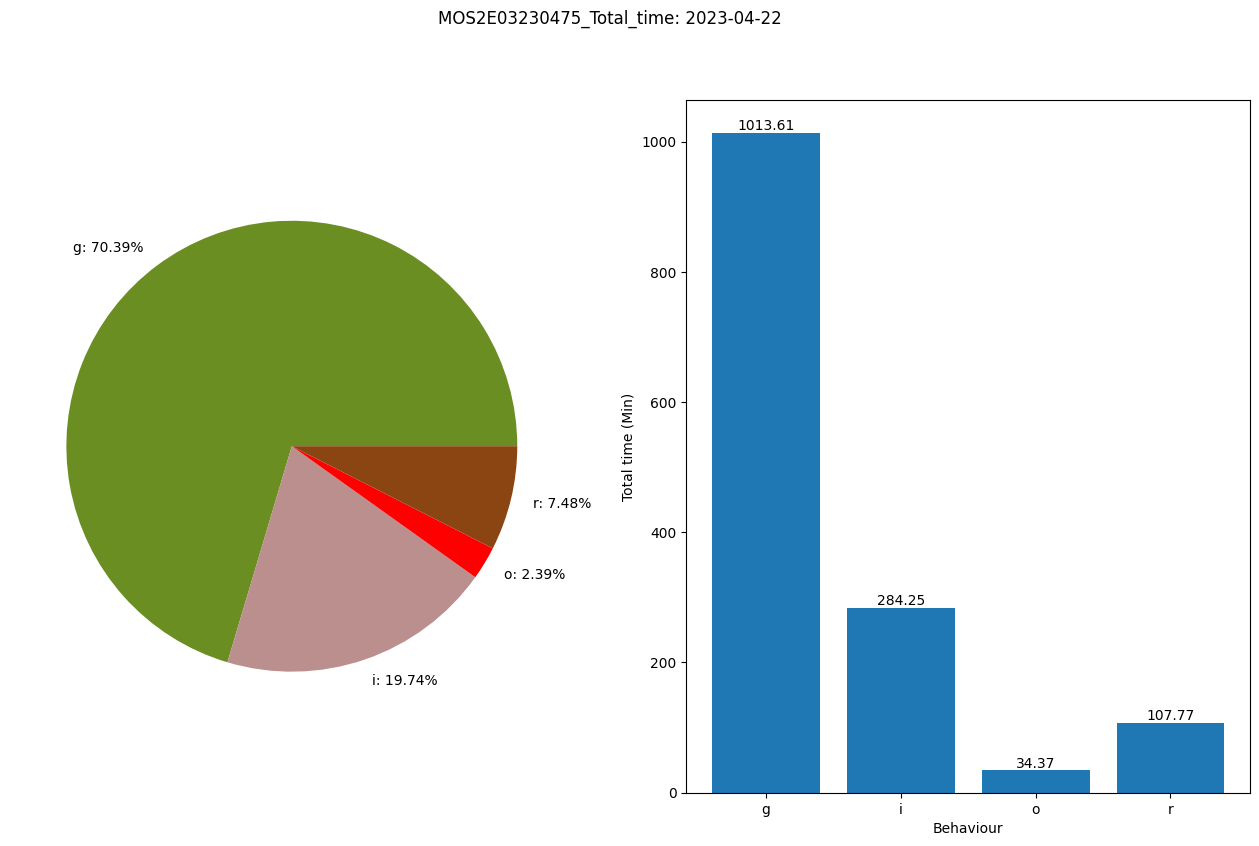

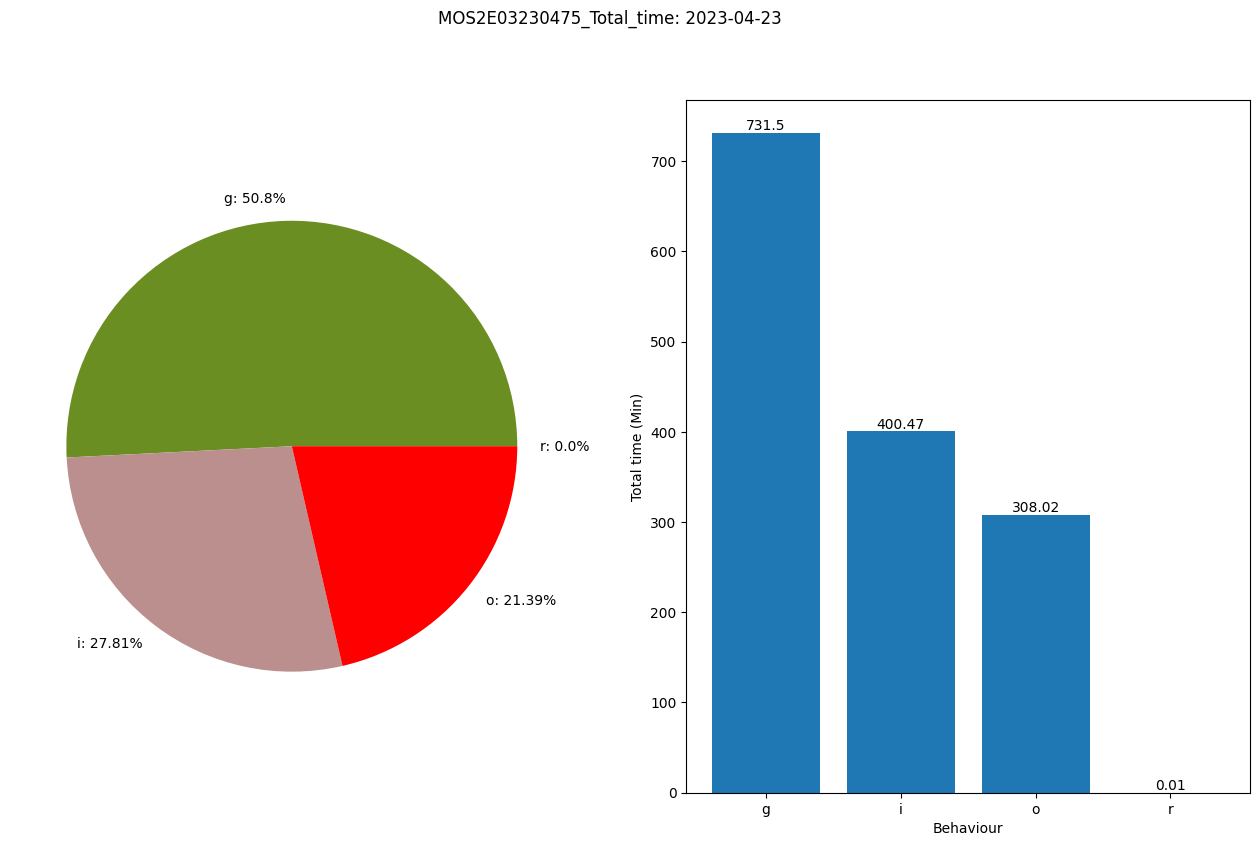

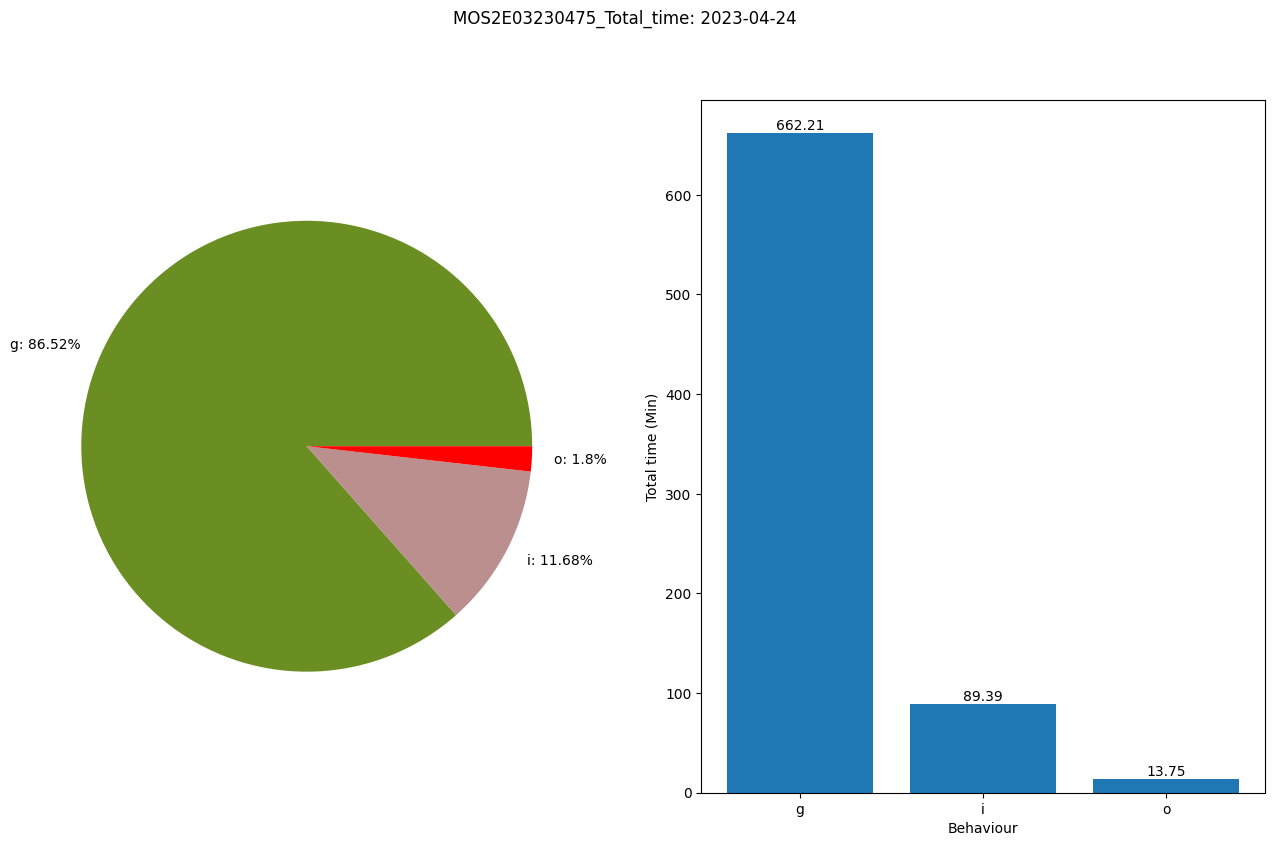

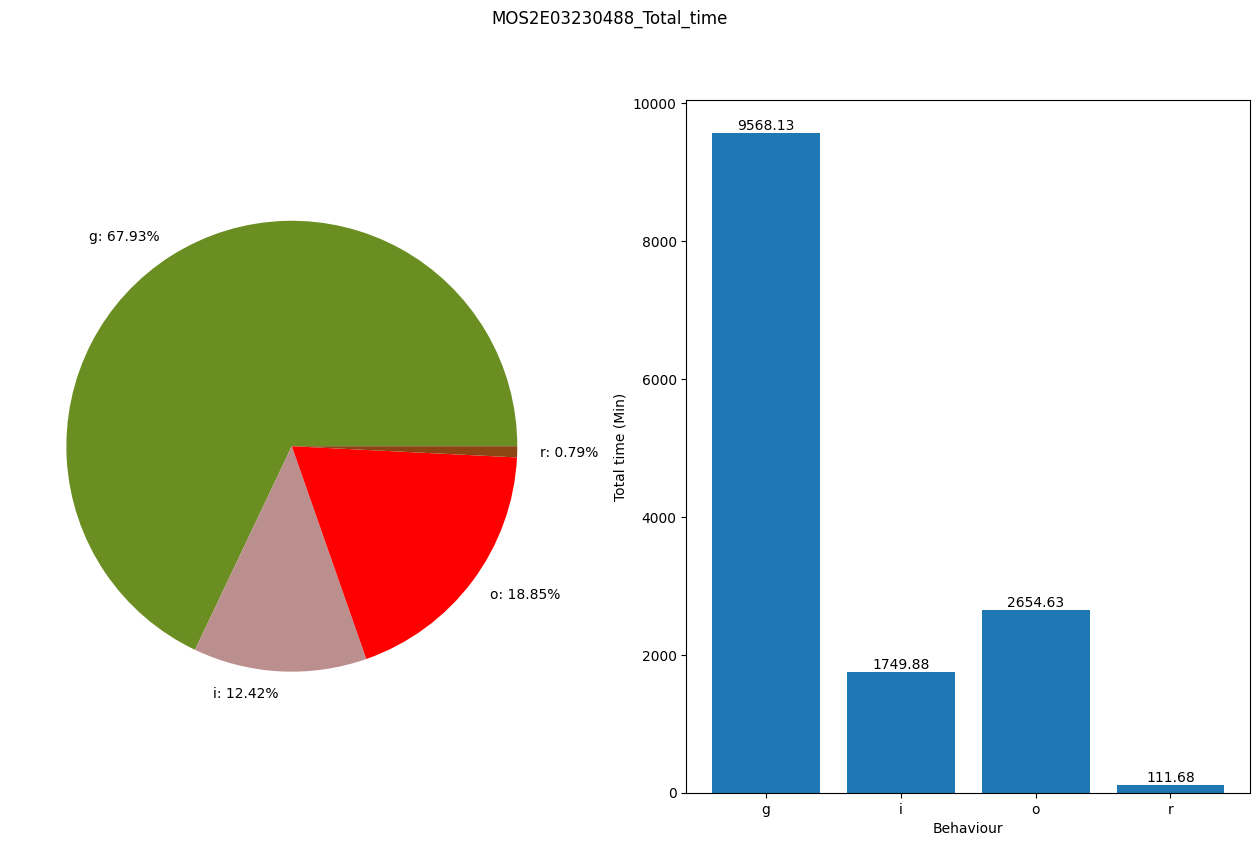

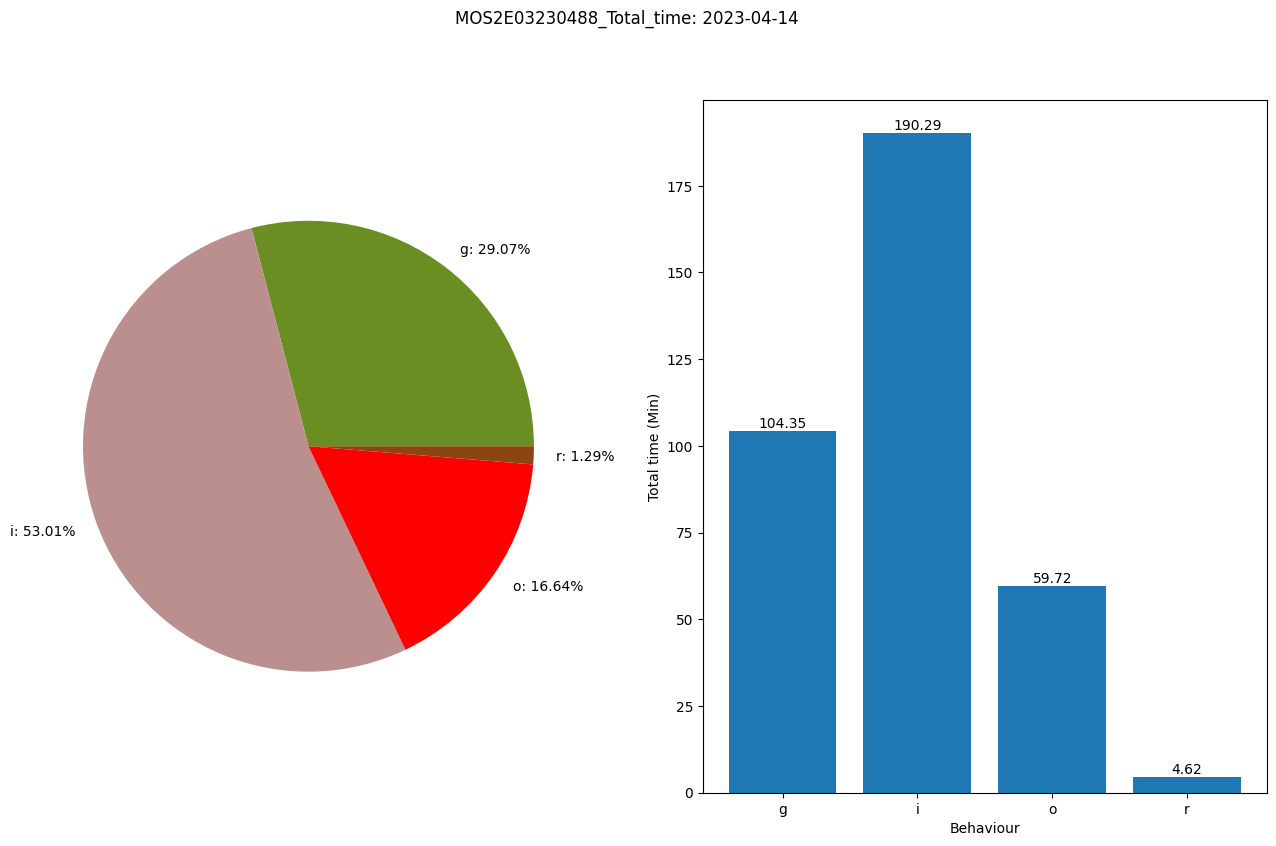

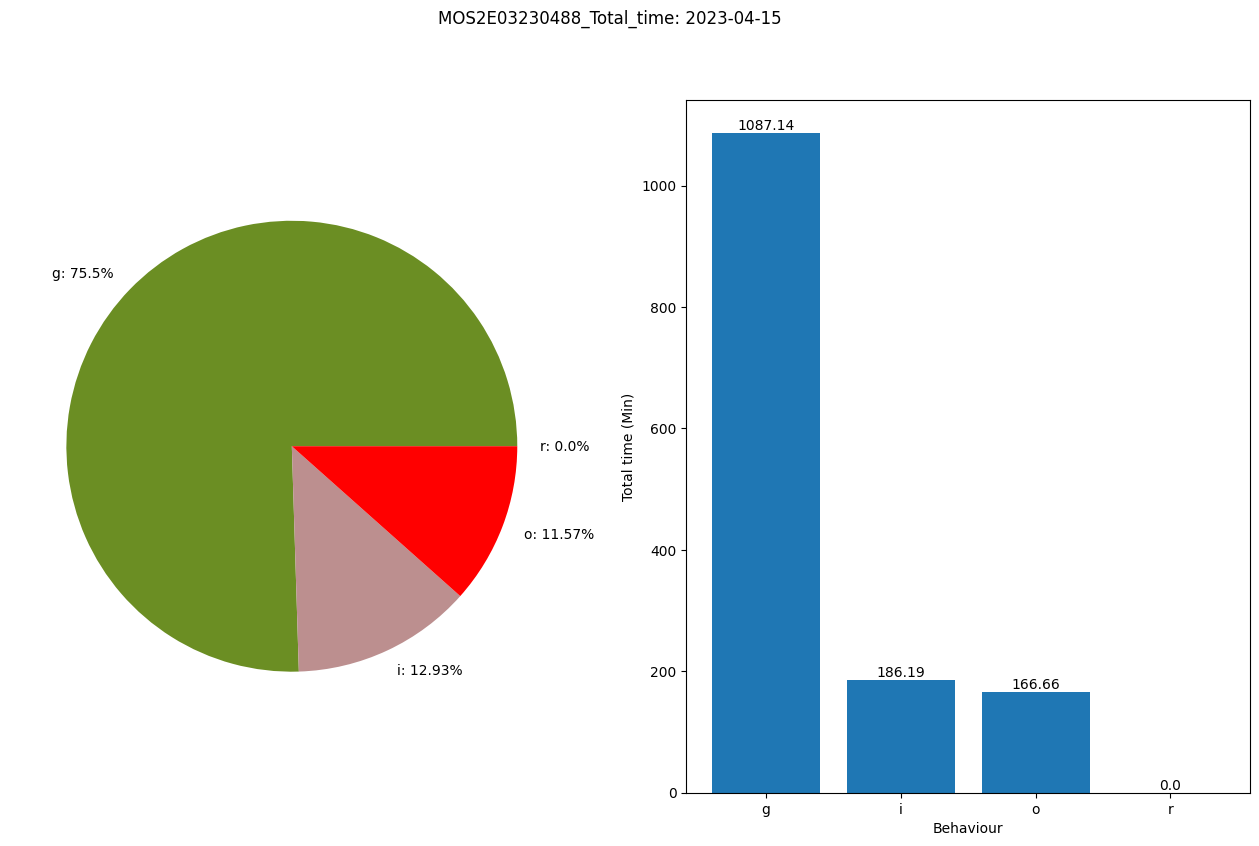

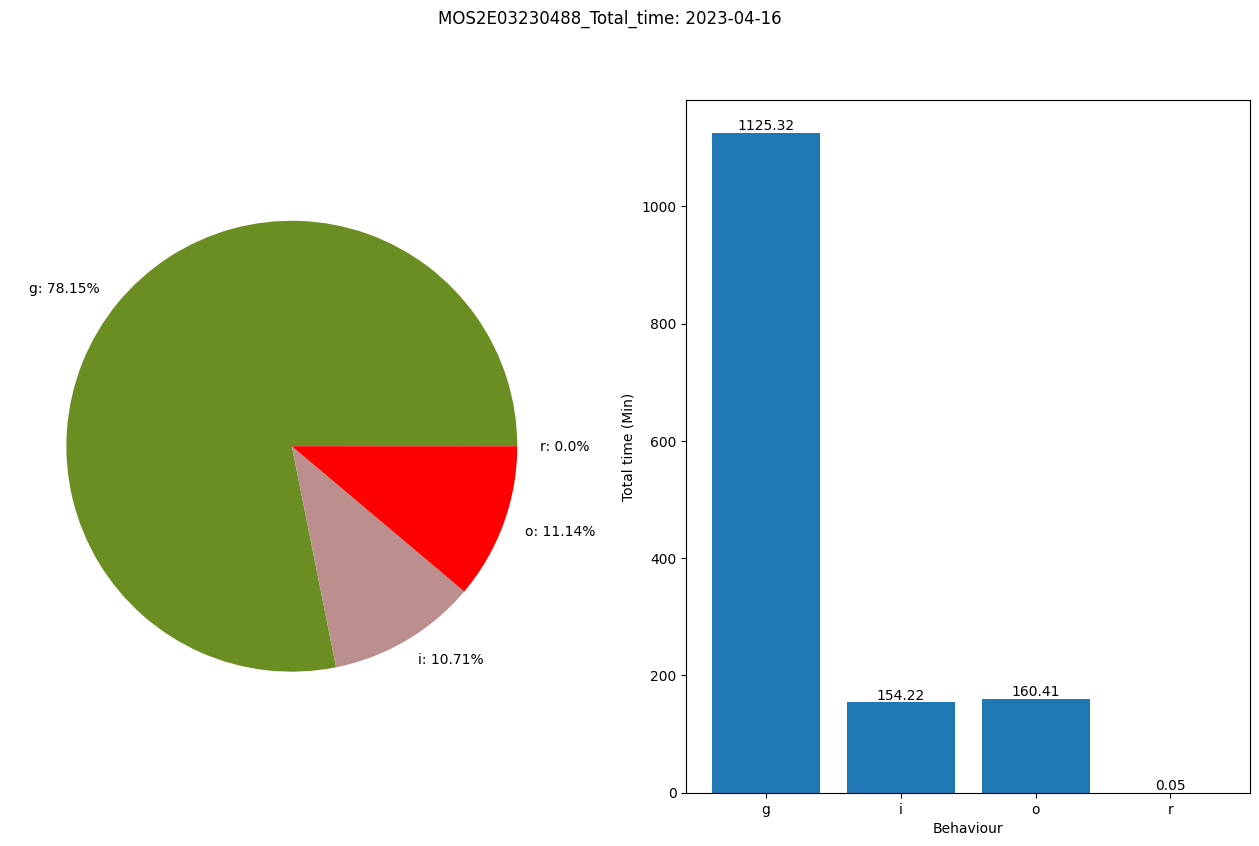

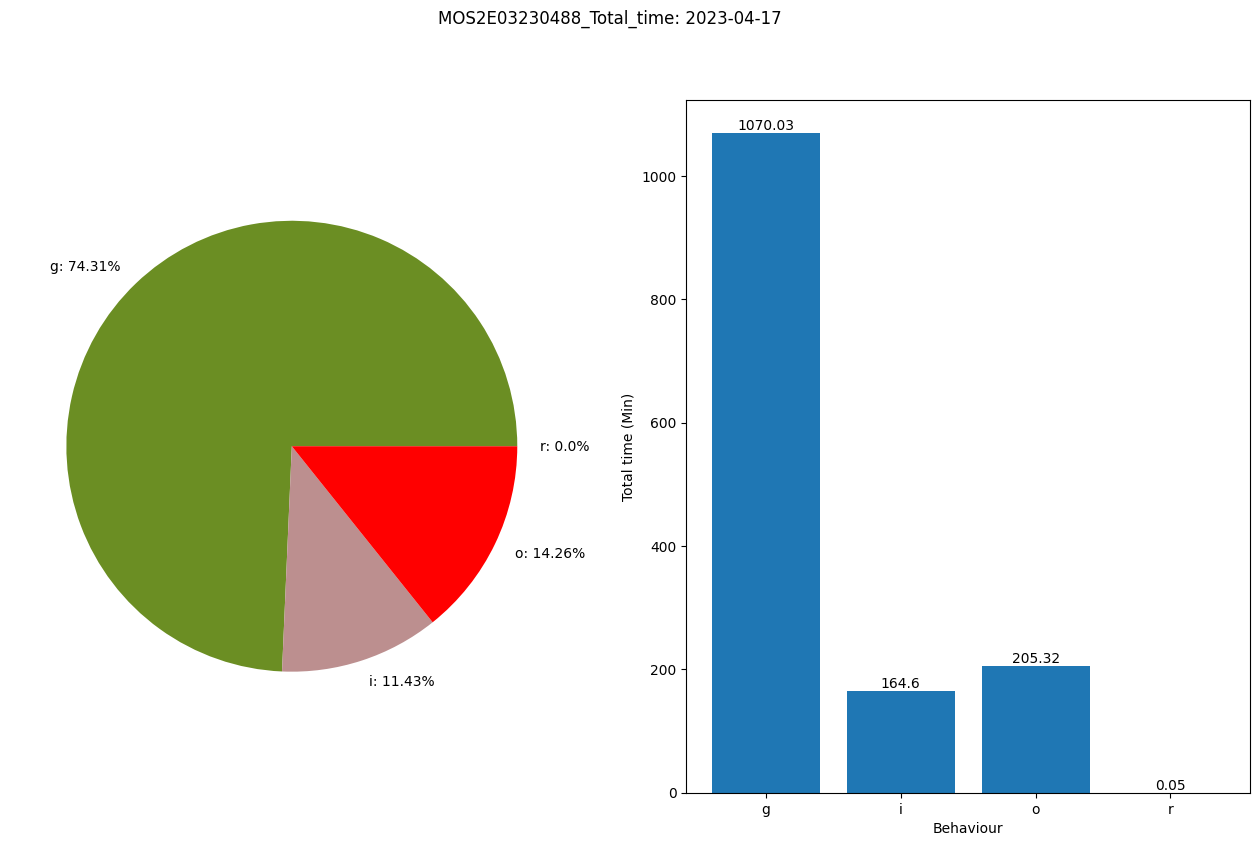

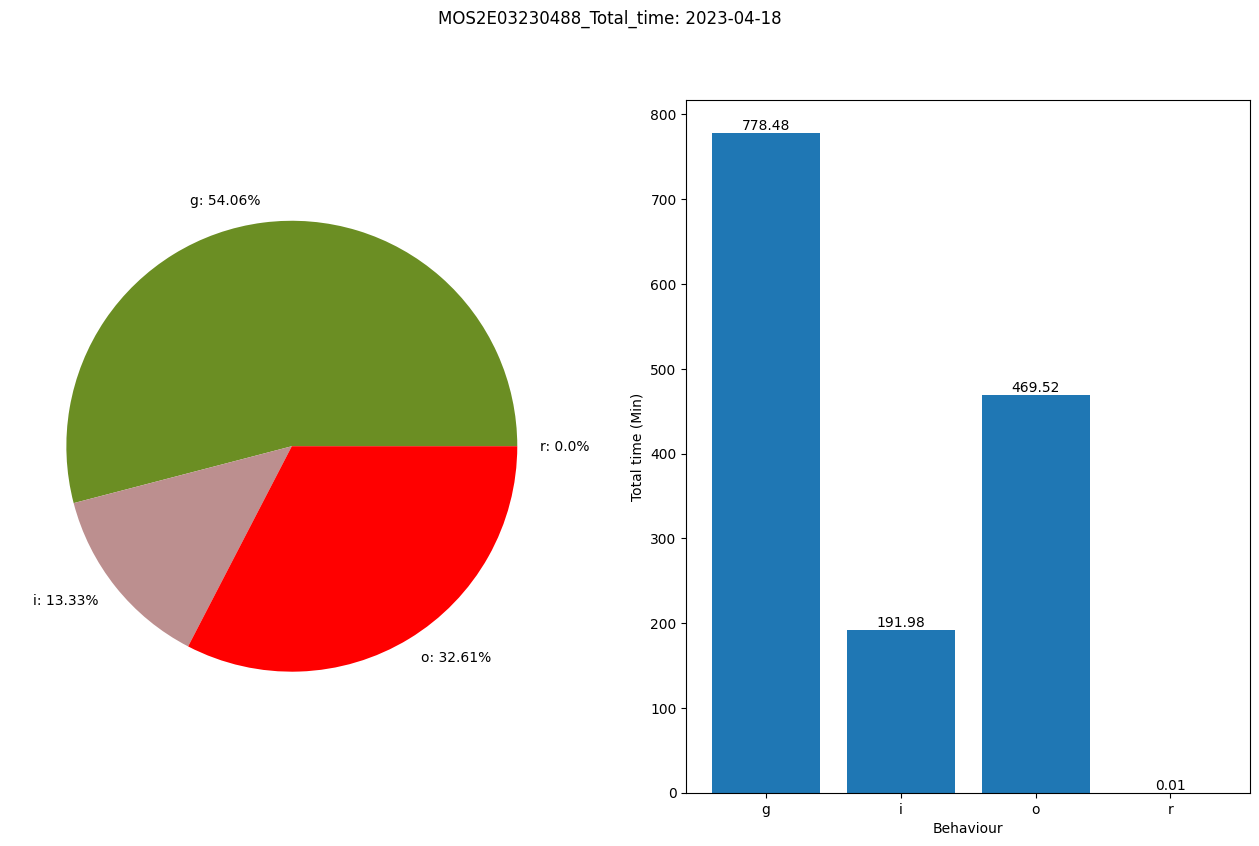

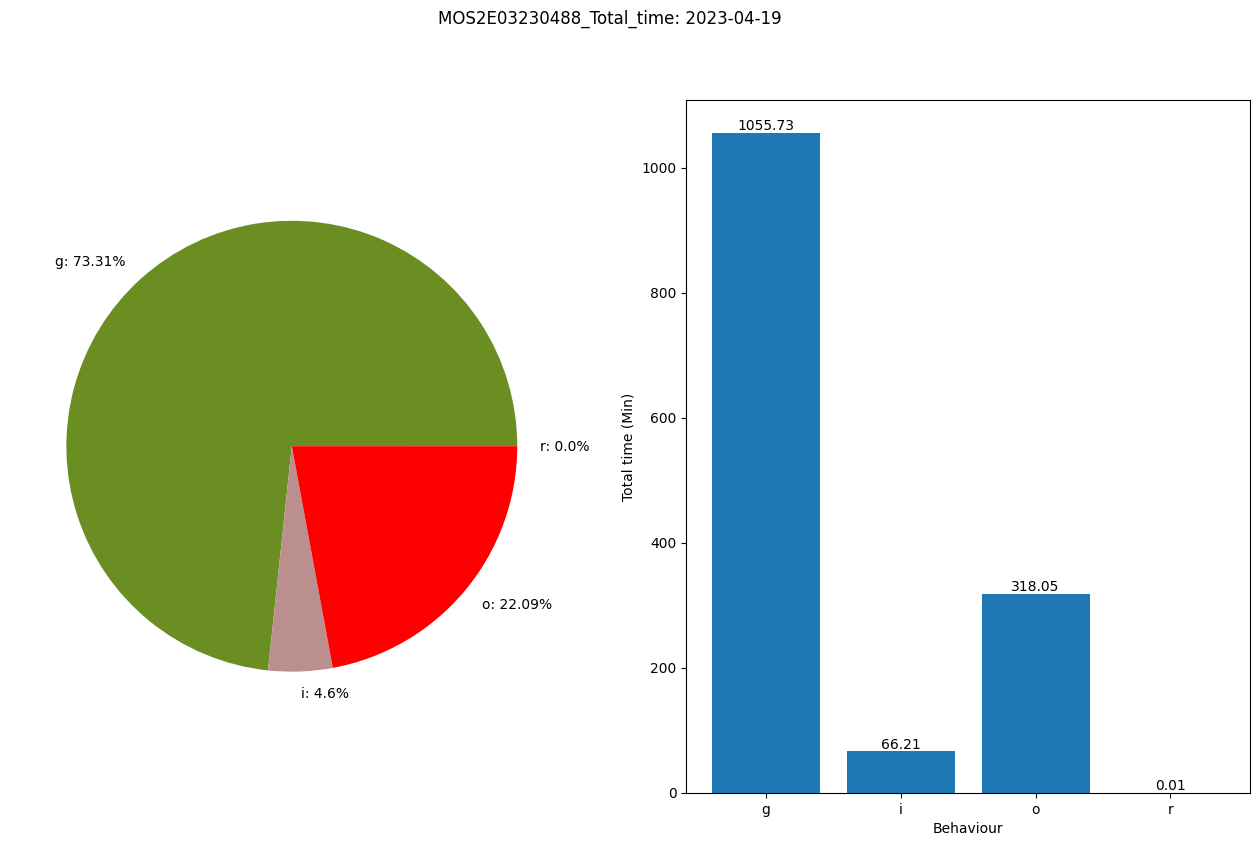

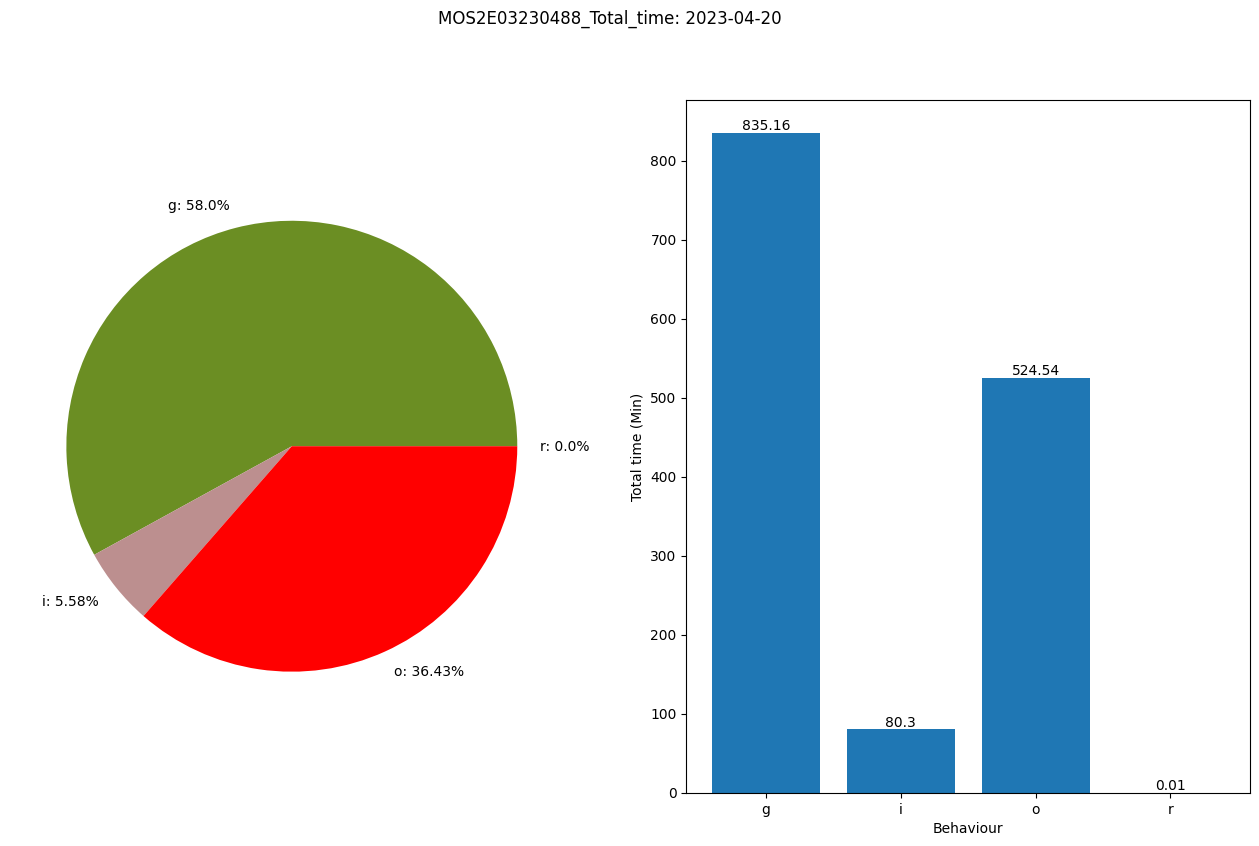

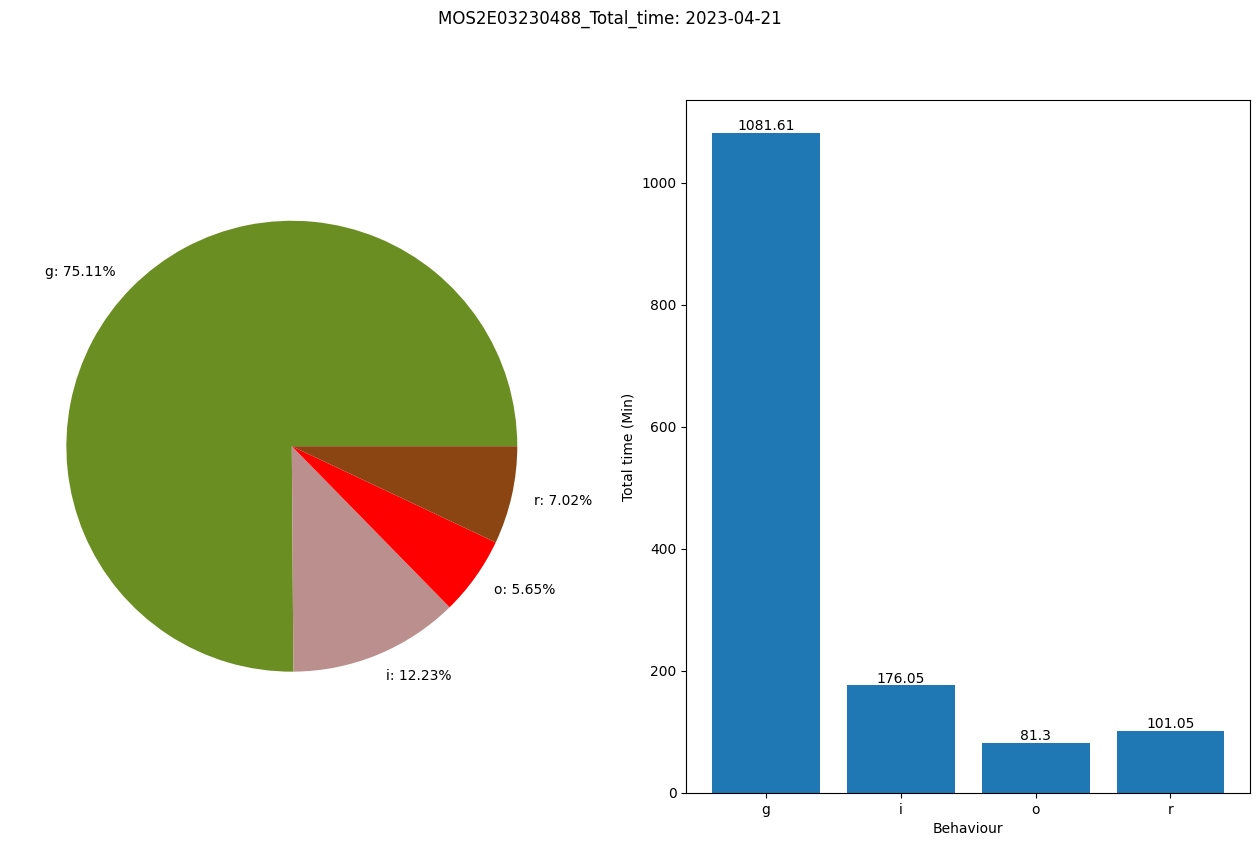

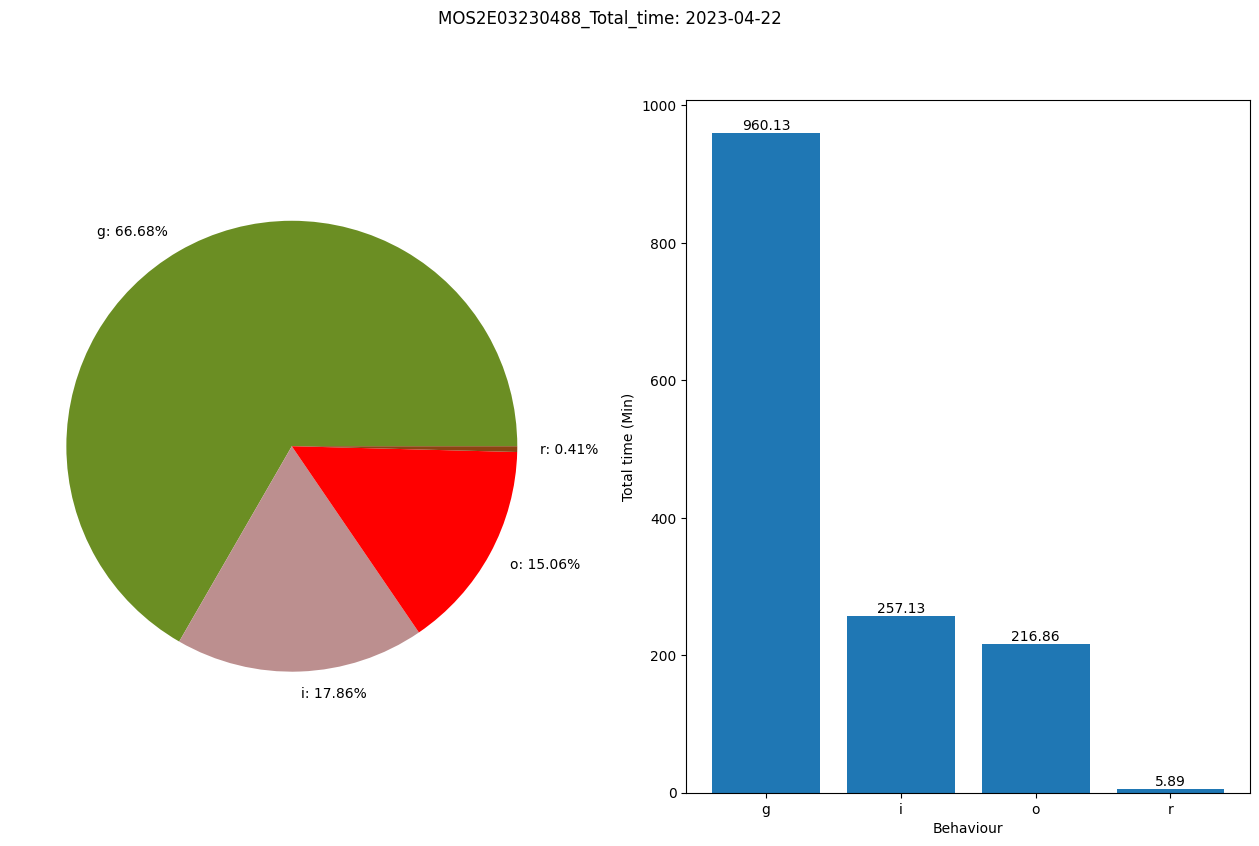

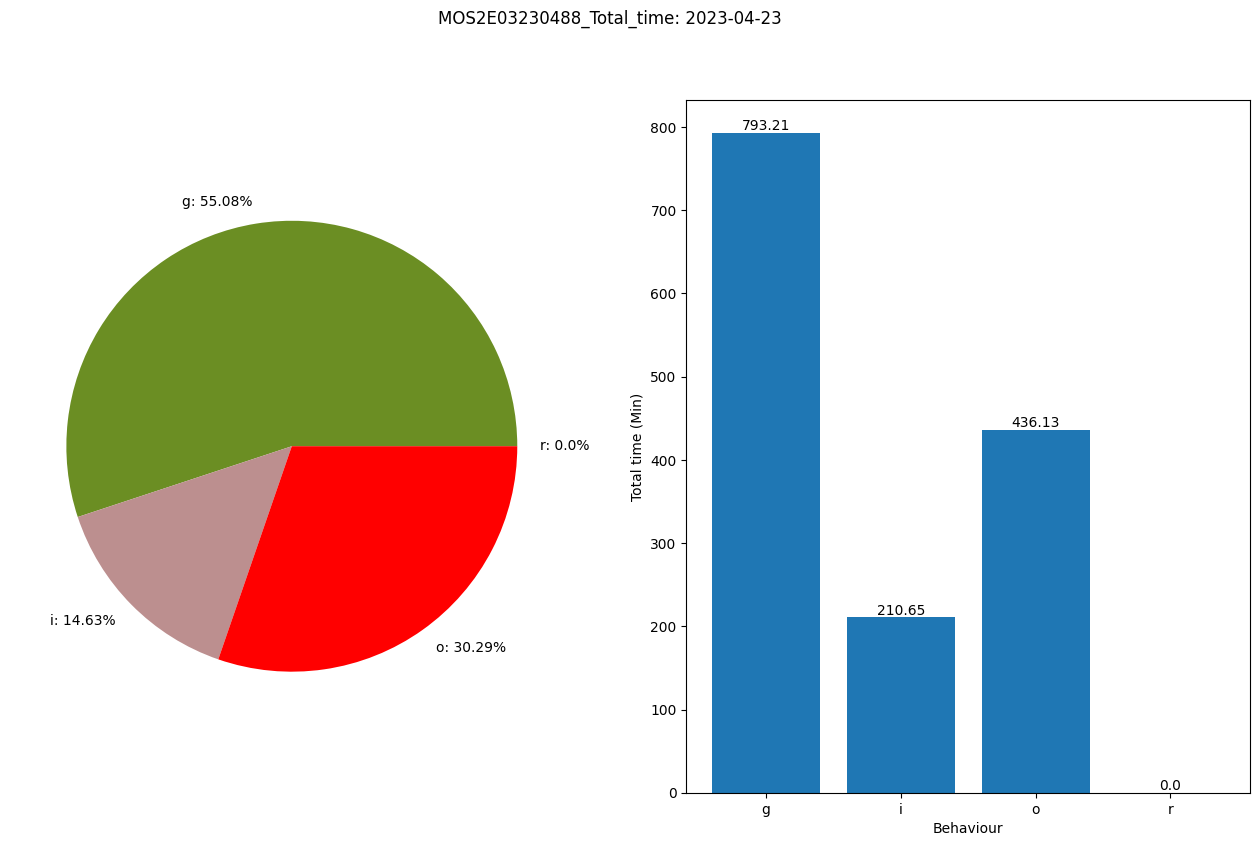

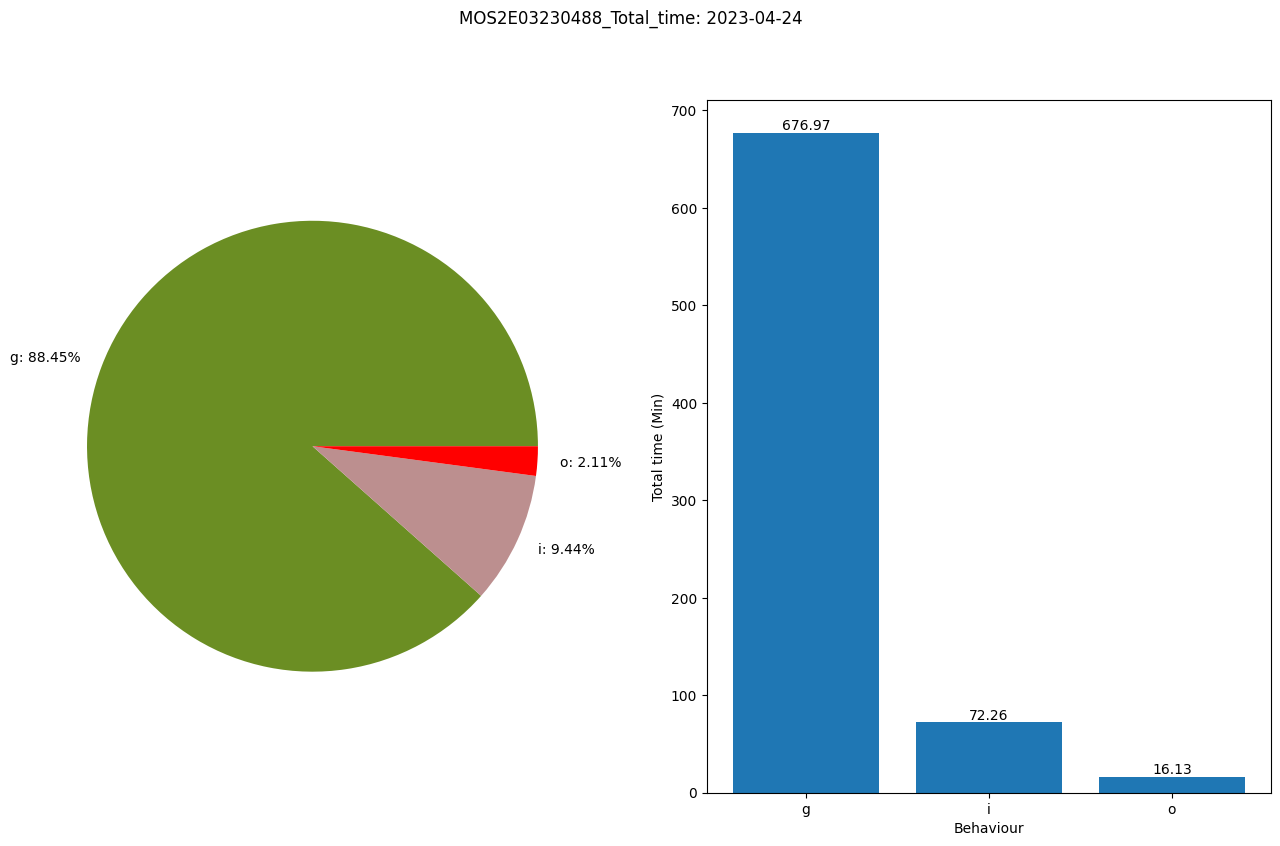

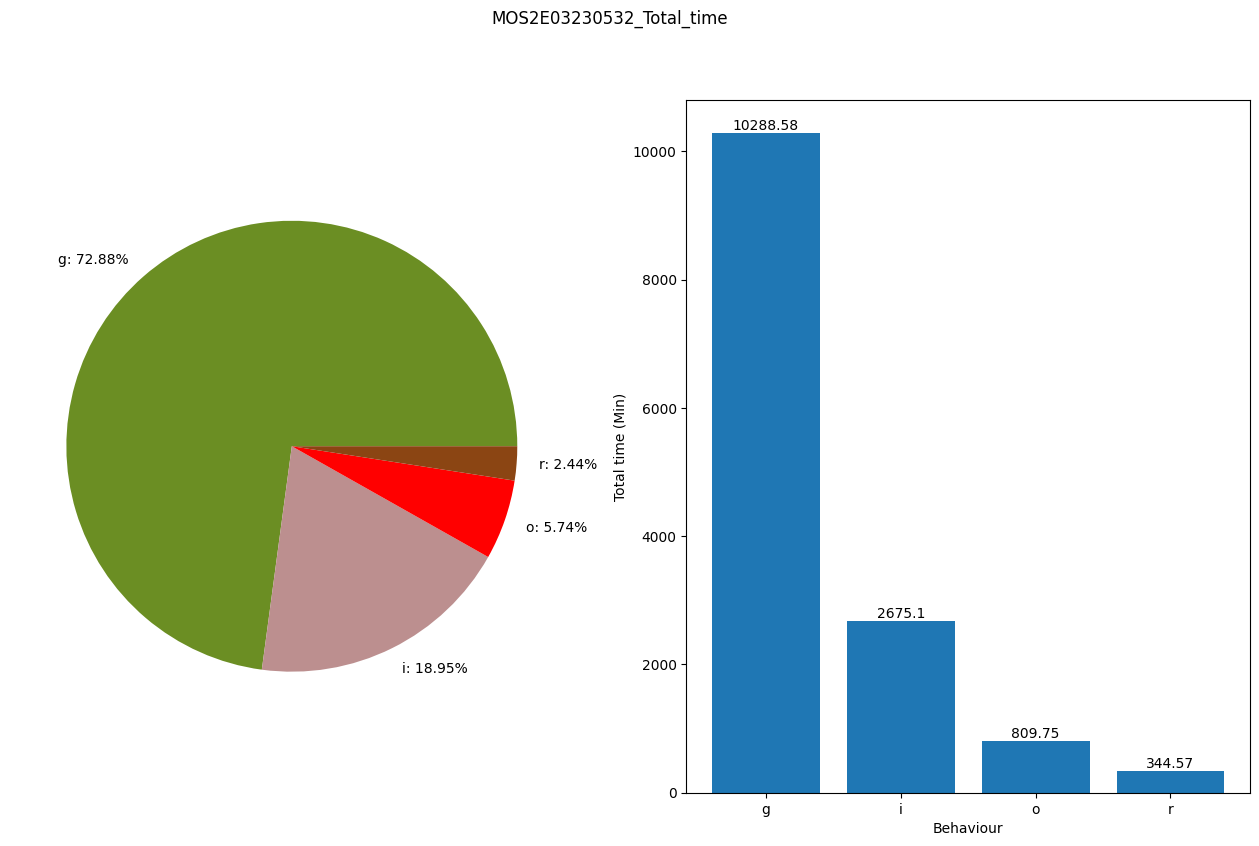

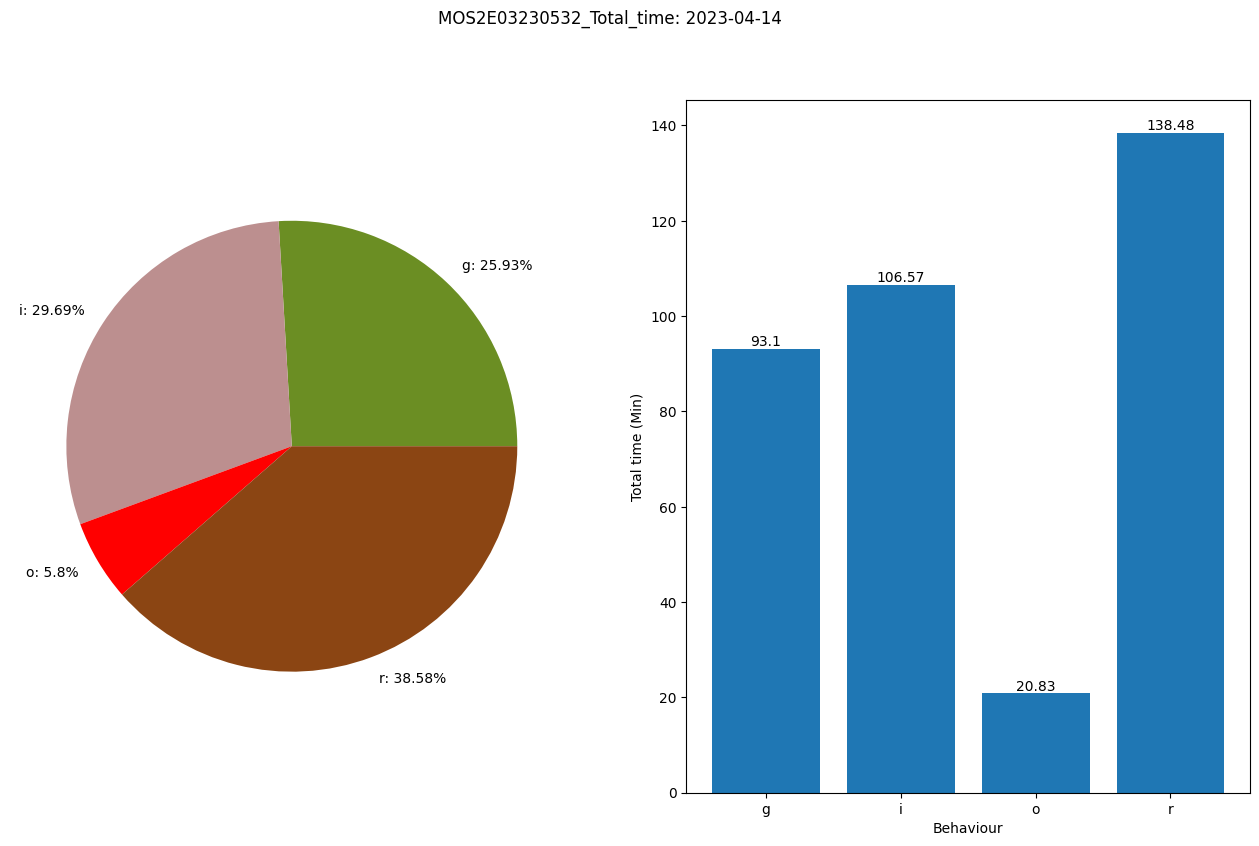

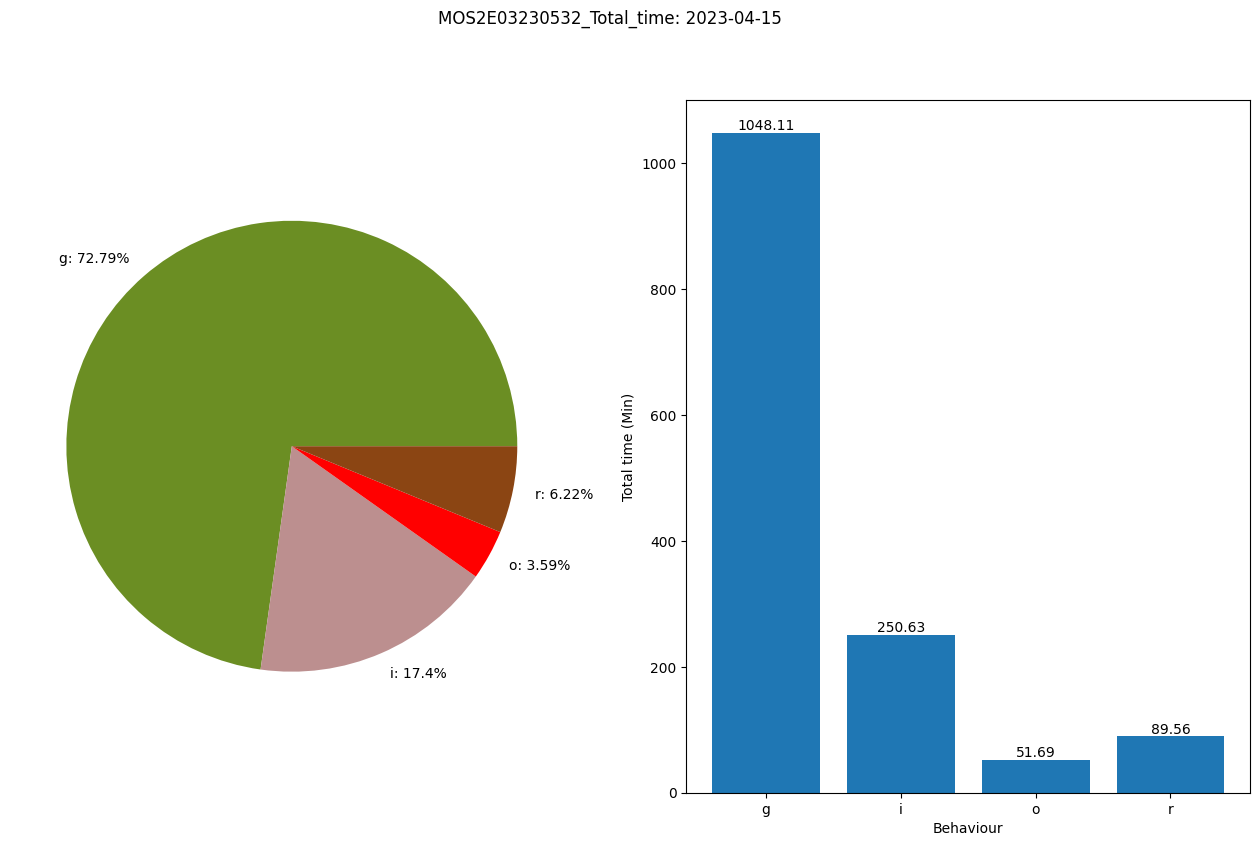

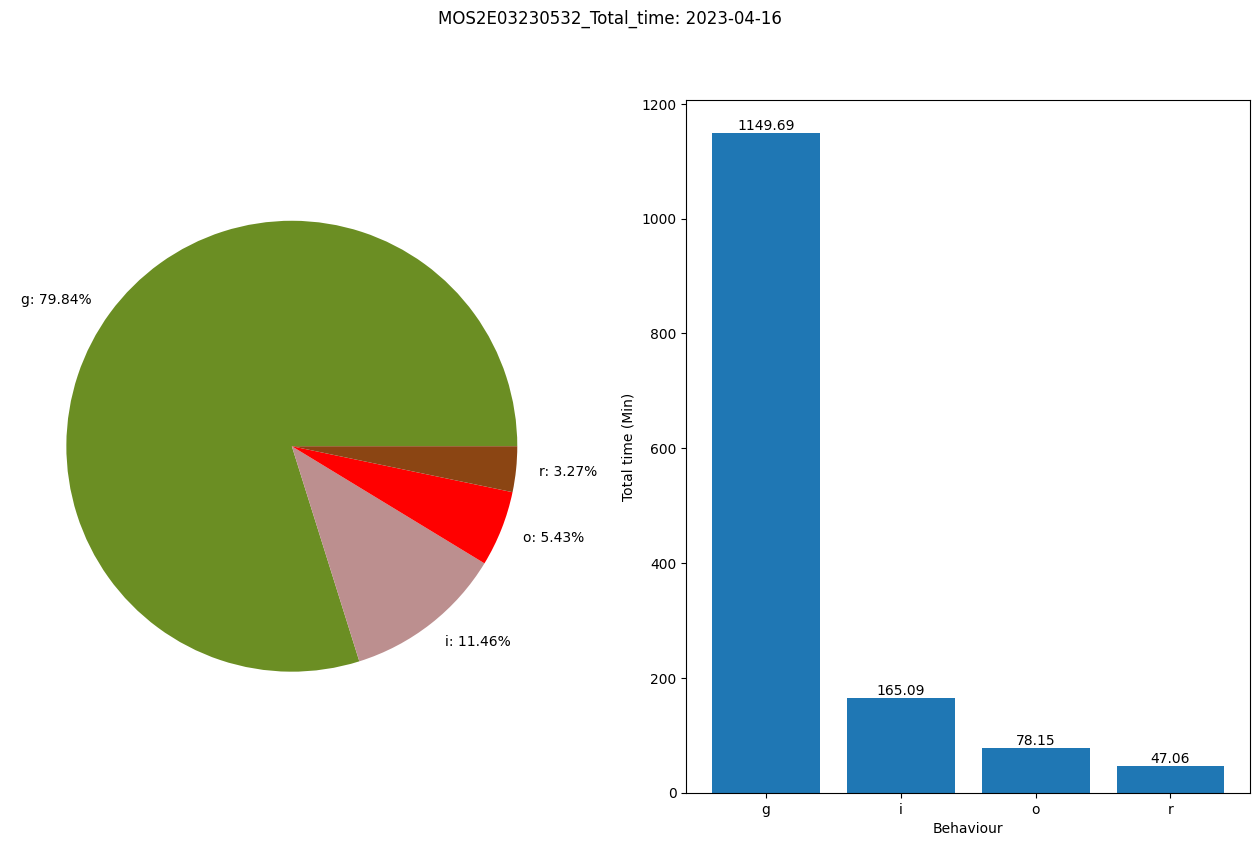

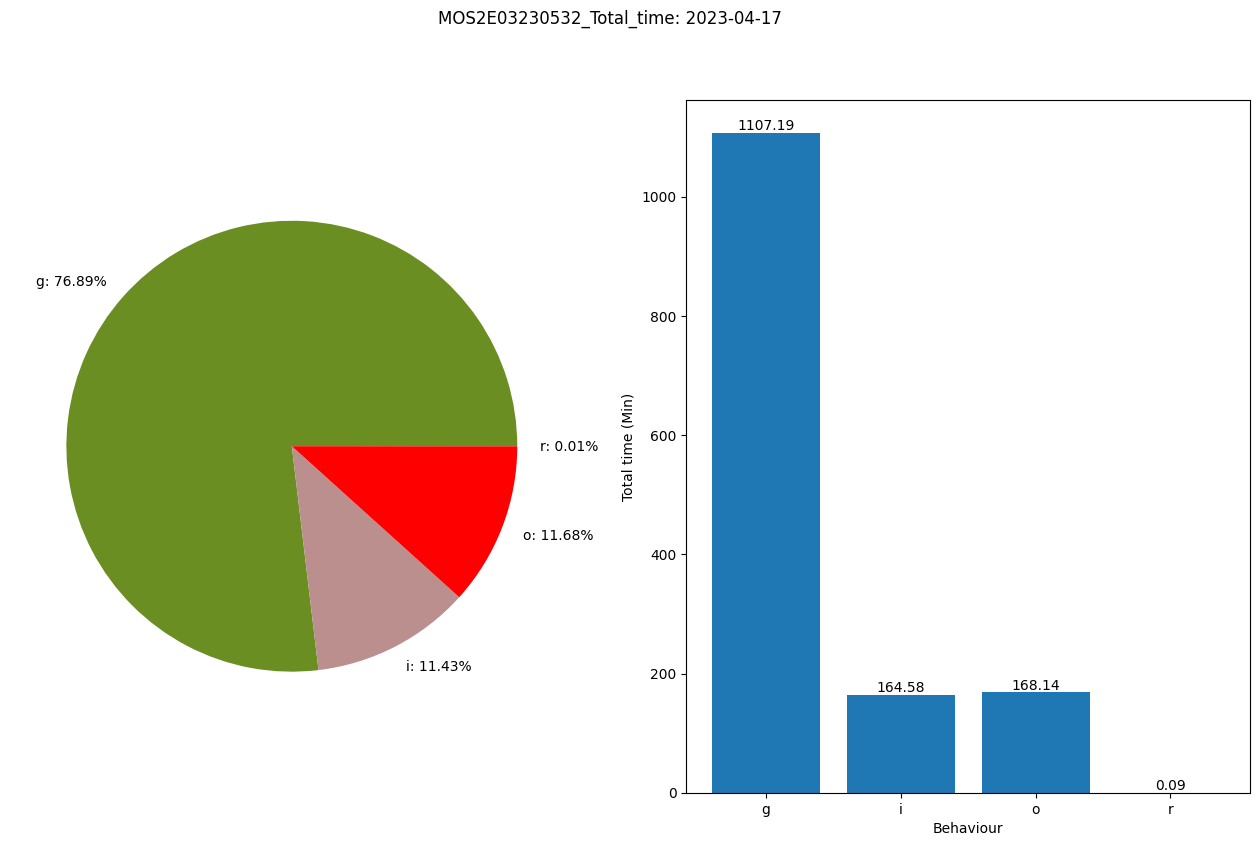

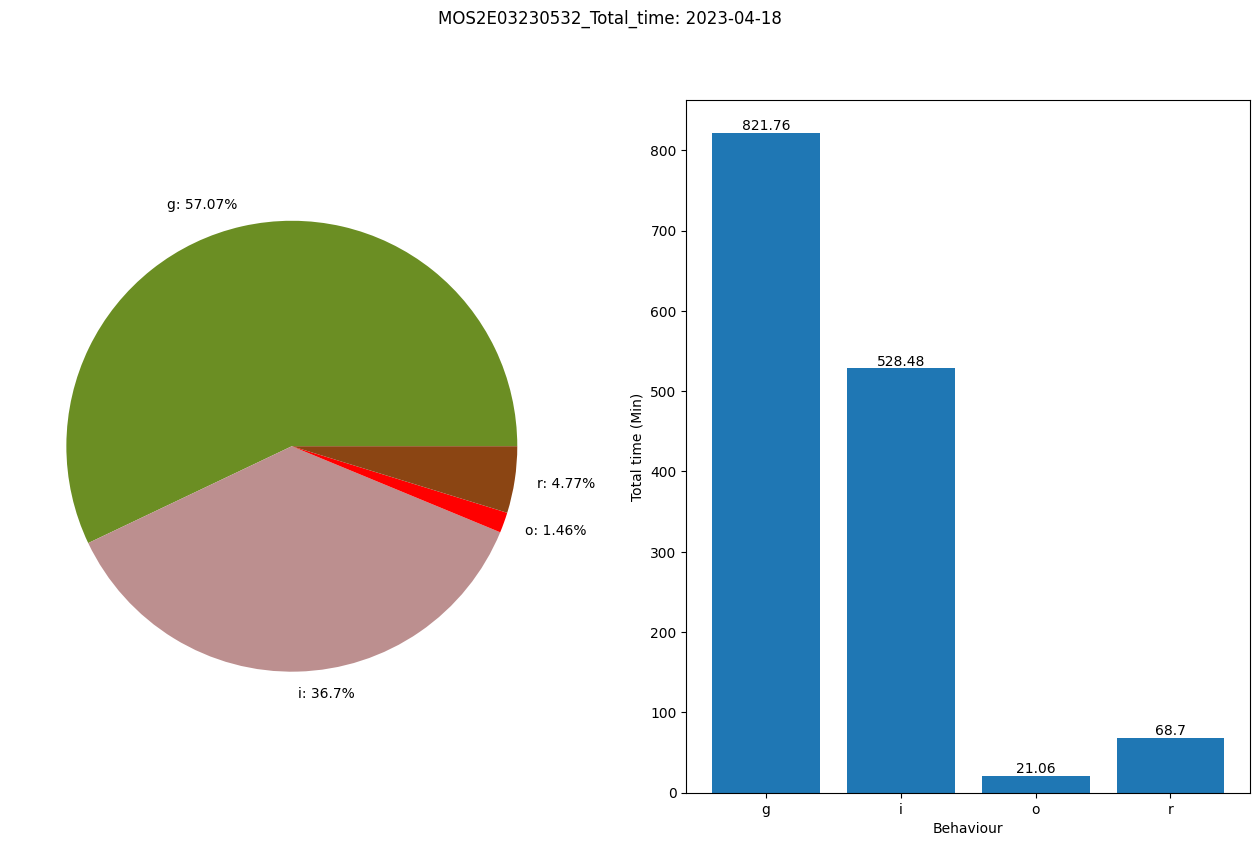

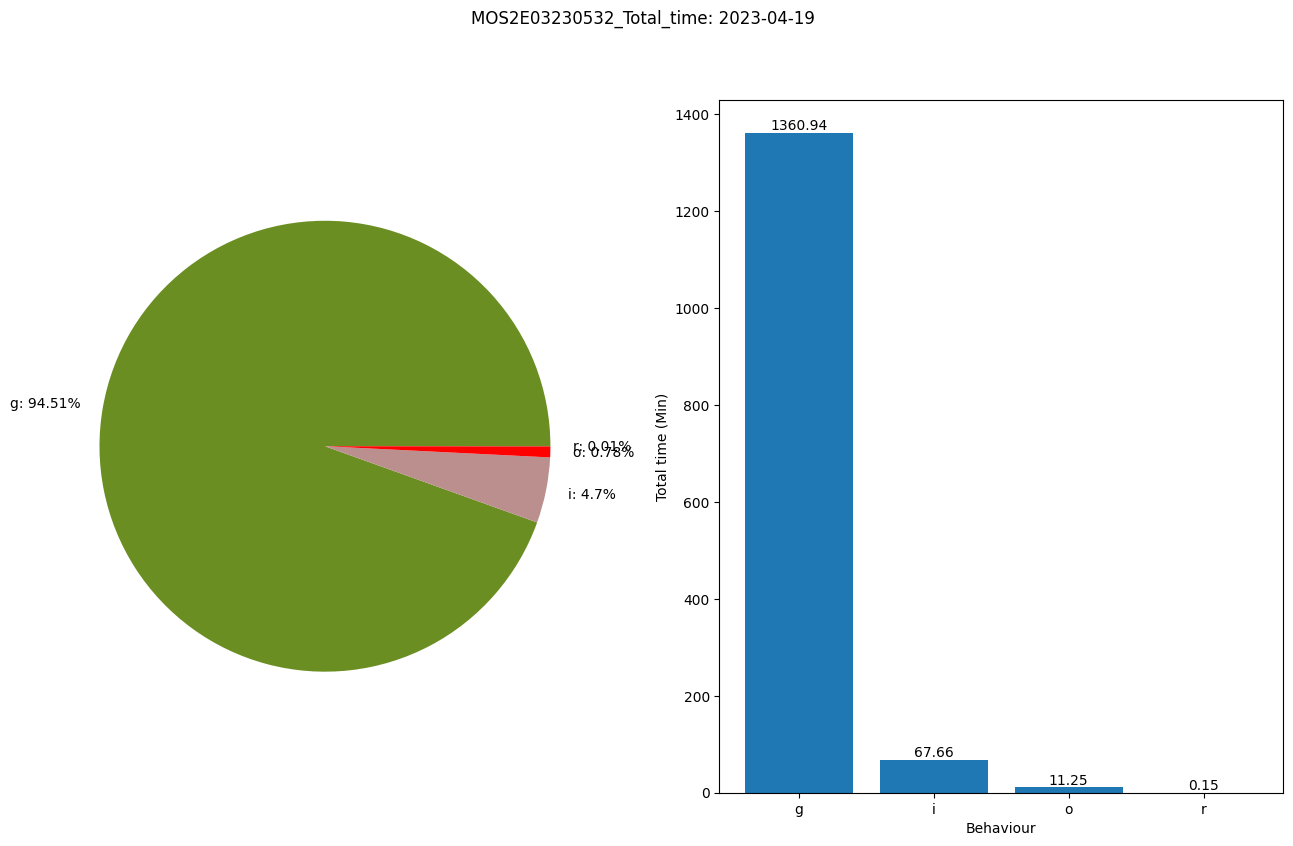

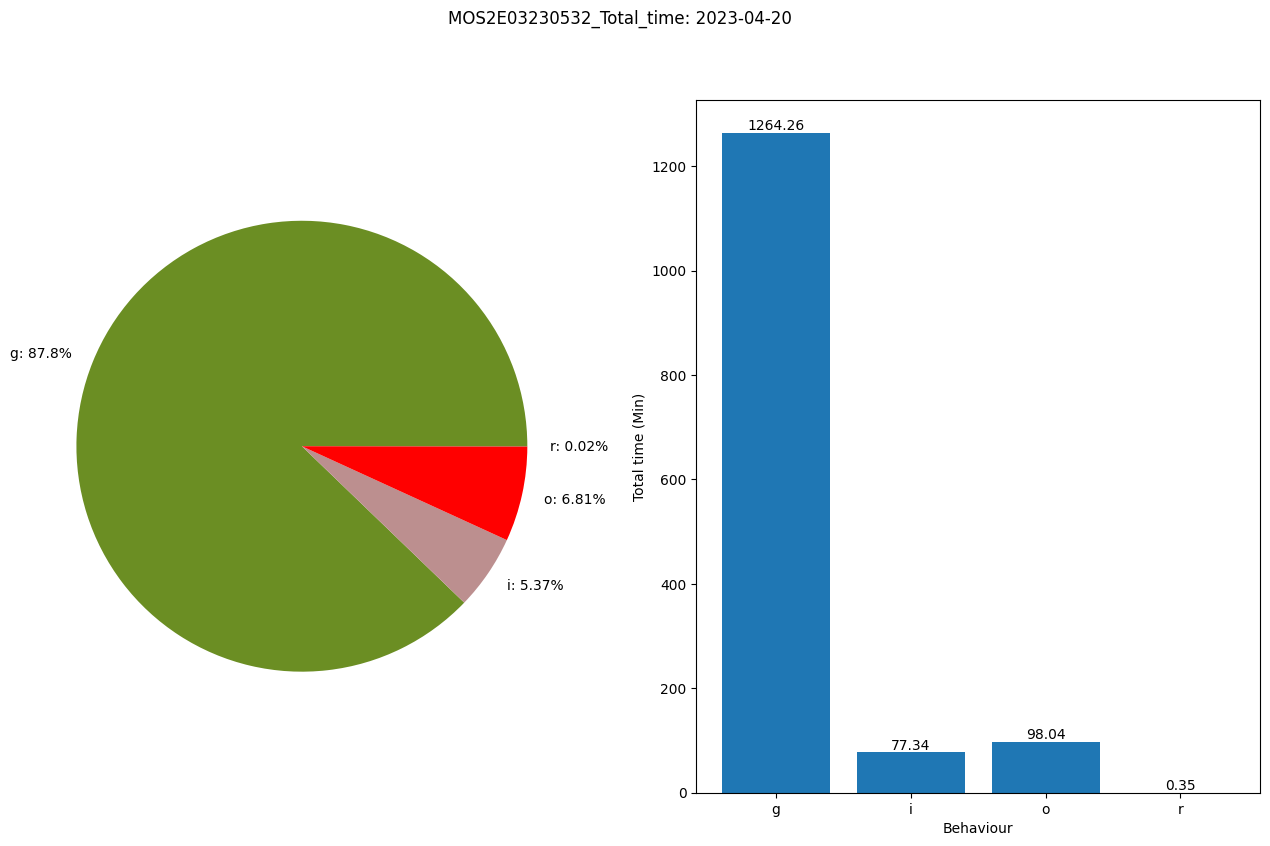

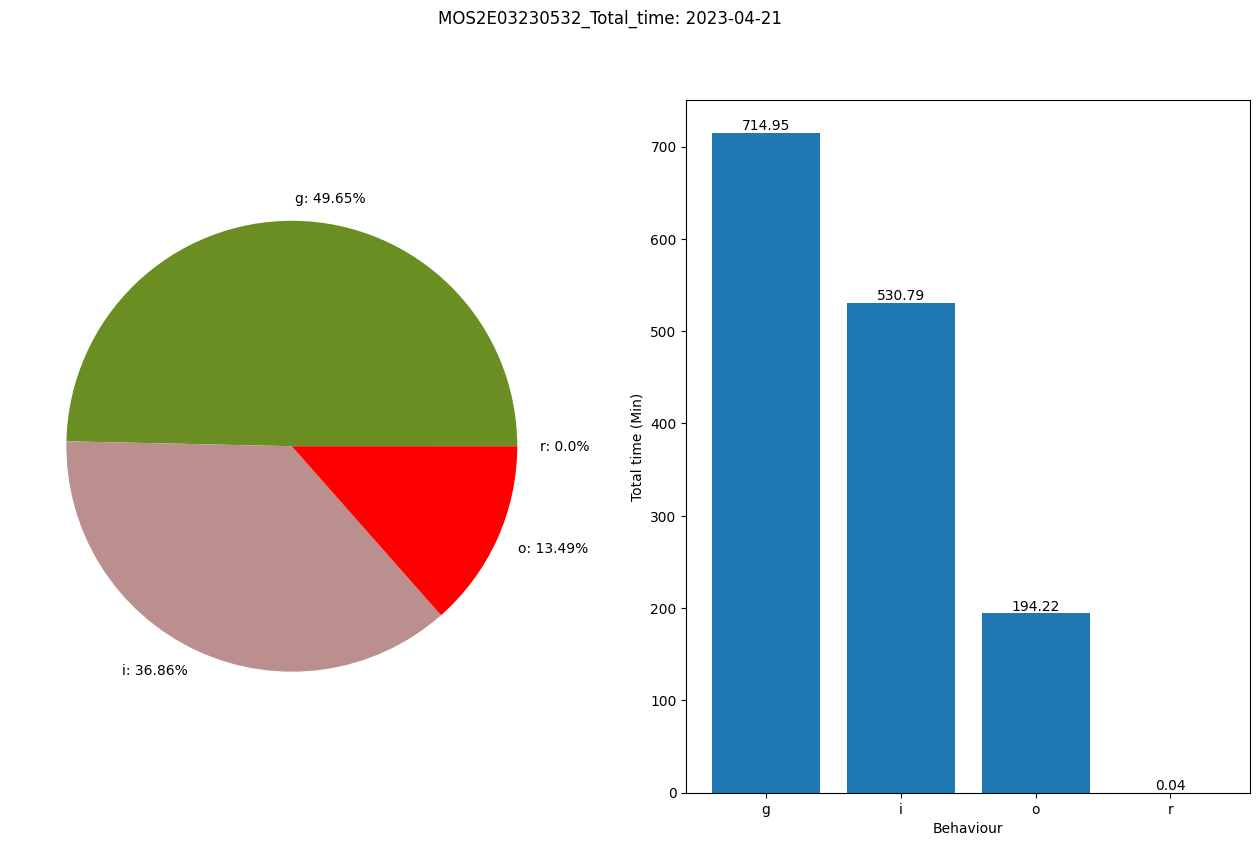

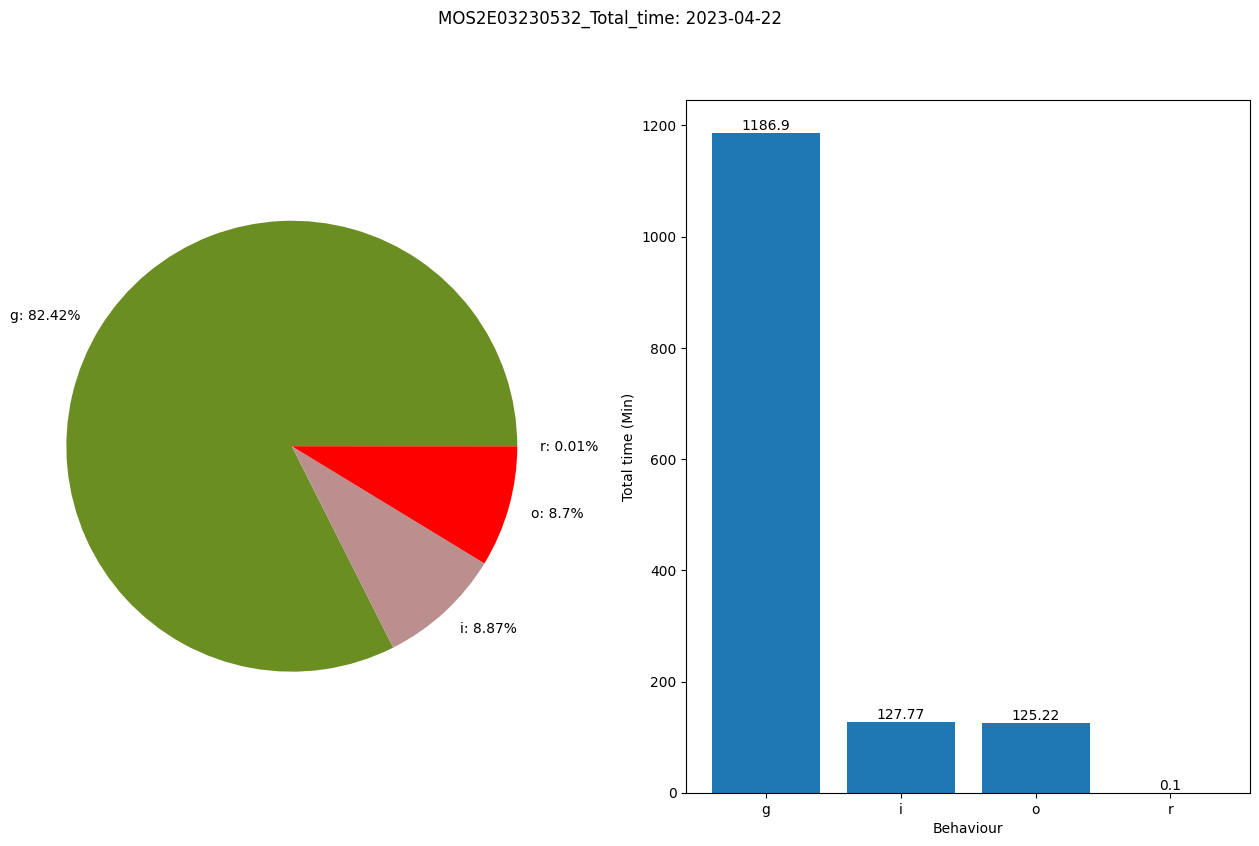

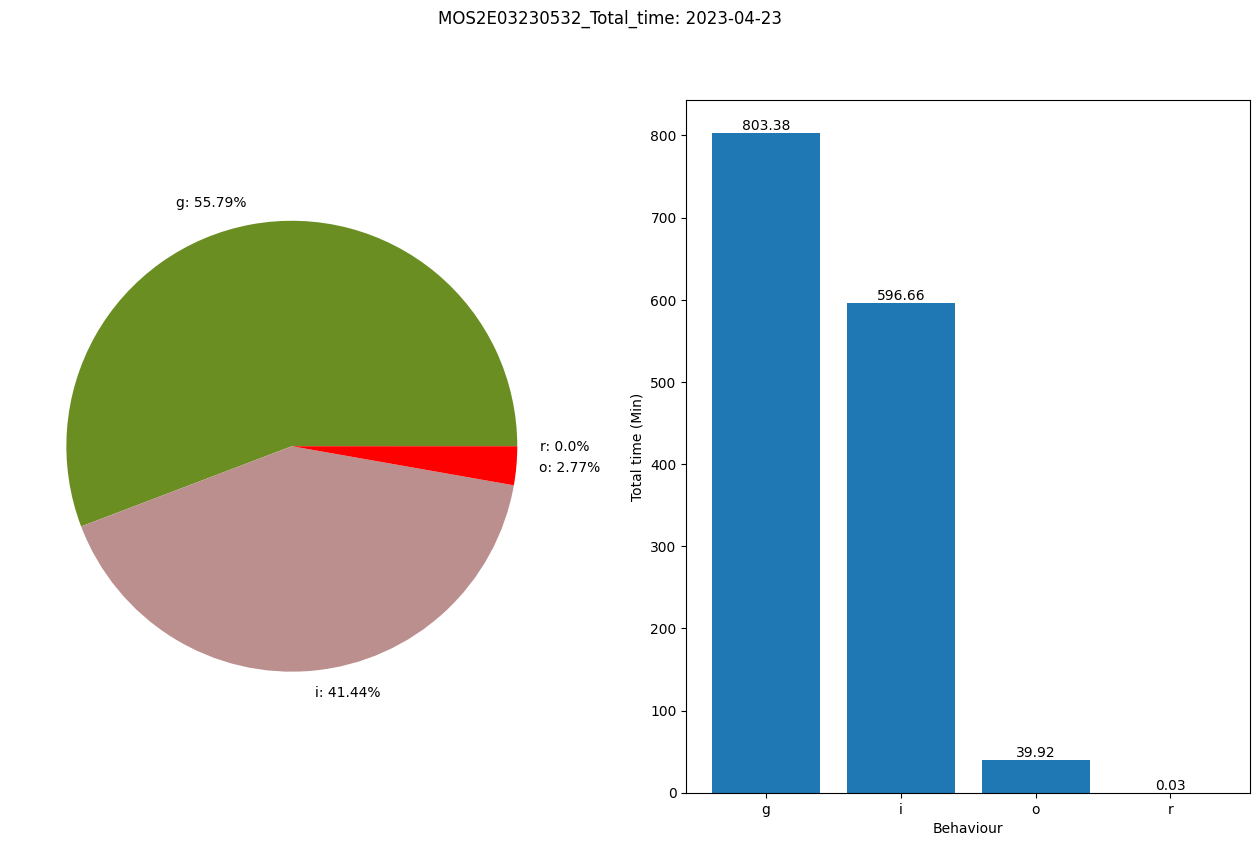

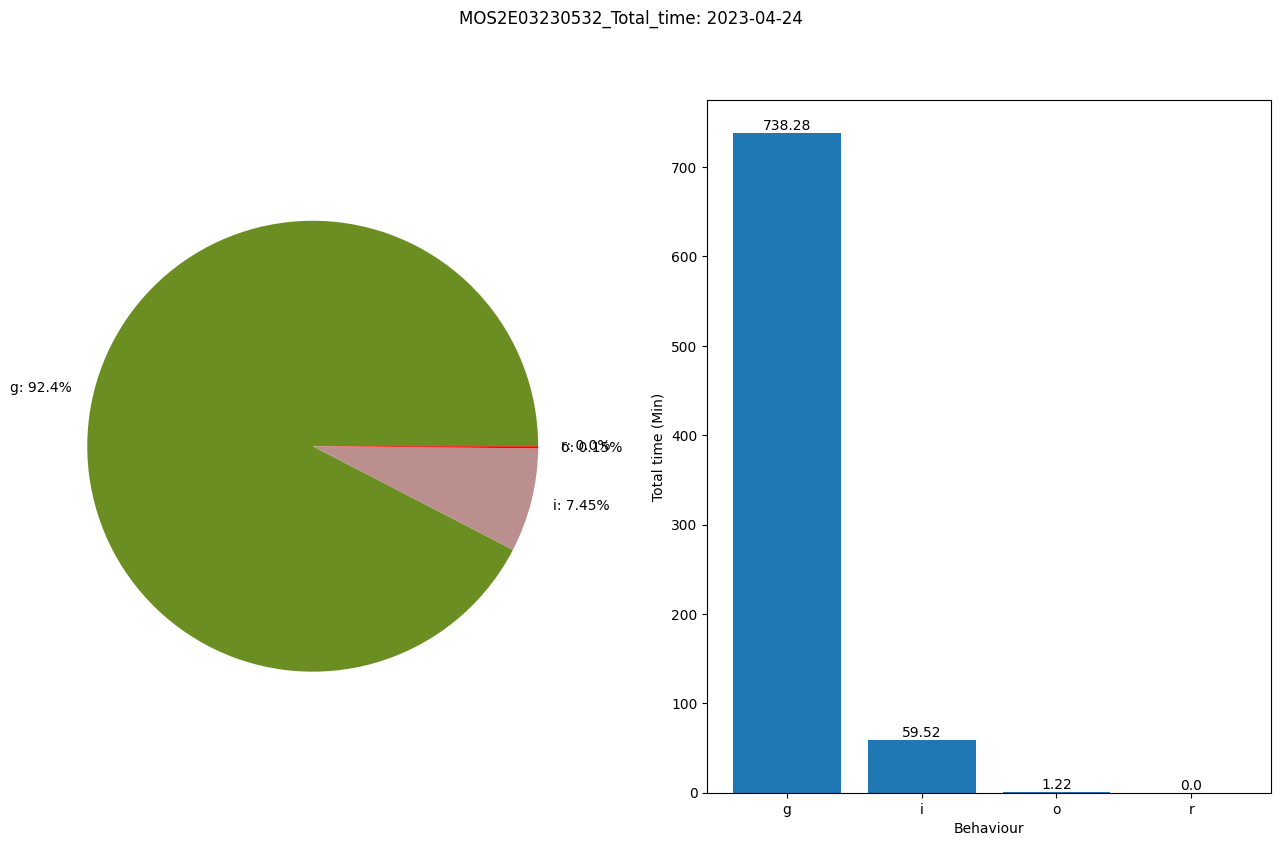

In [10]:
import shutil

import pandas
import visualisation

dated_df: list[pandas.DataFrame] = []
for f in input_files:
    current_sensor: str = f.stem.split(sep="_")[0]
    sensor_path: pathlib.PosixPath = pathlib.Path(OUTPUT_PATH, current_sensor).resolve()
    try:
        os.mkdir(path=pathlib.Path(sensor_path, "prediction_distribution").resolve())
        logging.info(msg="Start creating summaries for {}.".format(current_sensor))
    except FileExistsError:
        shutil.rmtree(
            path=pathlib.Path(sensor_path, "prediction_distribution").resolve()
        )
        os.mkdir(path=pathlib.Path(sensor_path, "prediction_distribution").resolve())
        logging.warning(
            msg="Start creating summaries for {} with ouput directory recreated.".format(
                current_sensor
            )
        )

    # Read the labelled data and convert the timestamp to date.
    df: pandas.DataFrame = pandas.read_csv(
        filepath_or_buffer=pathlib.Path(
            sensor_path,
            "{}_timestamp-label.csv".format(current_sensor),
        ).resolve(),
    )
    timestamps: pandas.DatetimeIndex = pandas.DatetimeIndex(df["timestamps"])
    days: pandas.Series = timestamps.date
    df["timestamps"] = days
    unique_days: list = list(df["timestamps"].unique())

    # Get the total length of all behaviours in minutes. The sensors read 30 rows of data
    # every seconds.
    labels: pandas.DataFrame = df.groupby(by=["predicted_labels"]).count().reset_index()
    labels = labels.rename(
        columns={labels.columns[-1]: "counts (mins)"},
        inplace=False,
    )
    labels[labels.columns[-1]] = labels[labels.columns[-1]] / (30 * 60)

    # Get the total length of all behaviours in minutes, for each respective day.
    daily_labels: pandas.DataFrame = (
        df.groupby(by=["timestamps", "predicted_labels"]).size().reset_index()
    )
    daily_labels = daily_labels.rename(
        columns={daily_labels.columns[-1]: "counts (mins)"},
        inplace=False,
    )
    daily_labels["counts (mins)"] = daily_labels["counts (mins)"] / (30 * 60)

    # Ouput the created DataFrames as csv files in the output directory.
    labels.to_csv(
        path_or_buf=pathlib.Path(
            sensor_path,
            "{}_total-count.csv".format(current_sensor),
        ).resolve(),
        sep=",",
        index=False,
    )
    daily_labels.to_csv(
        path_or_buf=pathlib.Path(
            sensor_path,
            "{}_count-by-day.csv".format(current_sensor),
        ).resolve(),
        sep=",",
        index=False,
    )

    # Add DataFrames to a list and start plotting the data.
    dated_df.clear()
    dated_df.append(labels)
    for day in unique_days:
        d_df: pandas.DataFrame = daily_labels.loc[daily_labels["timestamps"] == day]
        dated_df.append(d_df)
    visualisation.multiday_plotter(
        daily_sensor_df=dated_df,
        sensor_name=current_sensor,
        output_path=pathlib.Path(sensor_path, "prediction_distribution").resolve(),
    )